In [1]:
%matplotlib inline

import numpy as np
import scipy as sp
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt

import radical.utils as ru
import radical.pilot as rp
import radical.analytics as ra

from IPython.core.display import display, HTML

pd.set_option('expand_frame_repr', False)
pd.set_option('display.max_rows', 50)

/Users/mturilli/Virtualenvs/RP-PAPER-IPDPS18/lib/python2.7/site-packages/radical/utils/atfork/stdlib_fixer.py:63: UserWarning: logging module already imported before fixup.
  warnings.warn('logging module already imported before fixup.')


In [2]:
# Global configurations
# ---------------------

# Expand the notebook to the width of the browser
display(HTML("<style>.container { width:100% !important; }</style>"))

# Matplotlib style
plt.style.use('seaborn-ticks')

# Use LaTeX and its body font for the diagrams' text.
mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.unicode'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif']  = ['Nimbus Roman Becker No9L']

# Font sizes
SIZE = 24
plt.rc('font', size=SIZE)  # controls default text sizes
plt.rc('axes', titlesize=SIZE)  # fontsize of the axes title
plt.rc('axes', labelsize=SIZE)  # fontsize of the x any y labels
plt.rc('xtick', labelsize=SIZE)  # fontsize of the tick labels
plt.rc('ytick', labelsize=SIZE)  # fontsize of the tick labels
plt.rc('legend', fontsize=SIZE-2)  # legend fontsize
plt.rc('figure', titlesize=SIZE)  # # size of the figure title

# Use thinner lines for axes to avoid distractions.
mpl.rcParams['axes.linewidth']    = 0.75
mpl.rcParams['xtick.major.width'] = 0.75
mpl.rcParams['xtick.minor.width'] = 0.75
mpl.rcParams['ytick.major.width'] = 0.75
mpl.rcParams['ytick.minor.width'] = 0.75
mpl.rcParams['lines.linewidth'] = 2


# Do not use a box for the legend to avoid distractions.
mpl.rcParams['legend.frameon'] = False

# Restore part of matplotlib 1.5 behavior
mpl.rcParams['patch.force_edgecolor'] = True
mpl.rcParams['errorbar.capsize'] = 3

# Helpers
# -------

# Use coordinated colors. These are the "Tableau 20" colors as 
# RGB. Each pair is strong/light. For a theory of color    
tableau20 = [(31 , 119, 180), (174, 199, 232), # blue        [ 0,1 ]
             (255, 127, 14 ), (255, 187, 120), # orange      [ 2,3 ]
             (44 , 160, 44 ), (152, 223, 138), # green       [ 4,5 ]
             (214, 39 , 40 ), (255, 152, 150), # red         [ 6,7 ]
             (148, 103, 189), (197, 176, 213), # purple      [ 8,9 ]
             (140, 86 , 75 ), (196, 156, 148), # brown       [10,11]
             (227, 119, 194), (247, 182, 210), # pink        [12,13]
             (188, 189, 34 ), (219, 219, 141), # yellow      [14,15]
             (23 , 190, 207), (158, 218, 229), # cyan        [16,17]
             (65 , 68 , 81 ), (96 , 99 , 106), # gray        [18,19]
             (127, 127, 127), (143, 135, 130), # gray        [20,21] 
             (165, 172, 175), (199, 199, 199), # gray        [22,23]
             (207, 207, 207)]                   # gray        [24]
  
# Scale the RGB values to the [0, 1] range, which is the format 
# matplotlib accepts.    
for i in range(len(tableau20)):  
    r, g, b = tableau20[i]  
    tableau20[i] = (r / 255., g / 255., b / 255.)    

# Return a single plot without right and top axes
def fig_setup():
    fig = plt.figure(figsize=(13,7))
    ax = fig.add_subplot(111)  
    ax.spines["top"].set_visible(False)  
    ax.spines["right"].set_visible(False)  
    ax.get_xaxis().tick_bottom()  
    ax.get_yaxis().tick_left()
    
    return fig, ax

In [3]:
# Load wrangled data saved in .csv files for both synapse, microbenchmarks and gromacs.
synapse_sessions = pd.read_csv('data/synapse/sessions.csv', index_col=0)
synapse_pilots = pd.read_csv('data/synapse/pilots.csv', index_col=0)
synapse_units = pd.read_csv('data/synapse/units.csv', index_col=0)

mb_sessions = pd.read_csv('data/microbenchmarks/sessions.csv', index_col=0)
mb_pilots = pd.read_csv('data/microbenchmarks/pilots.csv', index_col=0)
mb_units = pd.read_csv('data/microbenchmarks/units.csv', index_col=0)

gromacs_sessions = pd.read_csv('data/sessions.csv', index_col=0)
gromacs_pilots = pd.read_csv('data/pilots.csv', index_col=0)
gromacs_units = pd.read_csv('data/units.csv', index_col=0)

In [4]:
print 'Synapse: Total number of successful runs: %s' % synapse_sessions.shape[0]
print 'Synapse: Total number of pilots: %s' % synapse_pilots.shape[0]
print 'Synapse: Total number of units: %s\n' % synapse_units.shape[0]

print 'Microbenchmarks: Total number of successful runs: %s' % mb_sessions.shape[0]
print 'Microbenchmarks: Total number of pilots: %s' % mb_pilots.shape[0]
print 'Microbenchmarks: Total number of units: %s\n' % mb_units.shape[0]

print 'GROMACS: Total number of successful runs: %s' % gromacs_sessions.shape[0]
print 'GROMACS: Total number of pilots: %s' % gromacs_pilots.shape[0]
print 'GROMACS: Total number of units: %s' % gromacs_units.shape[0]

Synapse: Total number of successful runs: 9
Synapse: Total number of pilots: 9
Synapse: Total number of units: 5792

Microbenchmarks: Total number of successful runs: 3
Microbenchmarks: Total number of pilots: 3
Microbenchmarks: Total number of units: 5120

GROMACS: Total number of successful runs: 1
GROMACS: Total number of pilots: 1
GROMACS: Total number of units: 16384


# Synapse

## Weak Scaling (exp1)

Definitions: 
* Weak scalability: how the solution time varies with the number of processors for a fixed problem size per processor
* Ideal Runtime: the time taken by the workload to run on the given resources without any overhead
* Walltime: the walltime asked for the pilot
* Max Walltime: the maximum walltime that can be asked for the given size of the pilot

|N runs| N tasks | N core/task | N generations | N pilot | N core/pilot | Ideal Runtime  | Walltime | Max Walltime | Resource |
|------|---------|-------------|---------------|---------|--------------|----------------|----------|--------------|----------|
| 2    | 32      | 32          | 1             | 1       | 1024         | 15m            | 1h       | 1h           | Titan    |
| 2    | 64      | 32          | 1             | 1       | 2048         | 15m            | 1h       | 6h           | Titan    |
| 2    | 128     | 32          | 1             | 1       | 4096         | 15m            | 1h       | 6h           | Titan    |
| 2    | 256     | 32          | 1             | 1       | 8192         | 15m            | 1h       | 12h          | Titan    |
| 2    | 512     | 32          | 1             | 1       | 16384        | 15m            | 1h       | 12h          | Titan    |
| 2    | 1024    | 32          | 1             | 1       | 32768        | 15m            | 1h       | 12h          | Titan    |
| 2    | 2048    | 32          | 1             | 1       | 65536        | 15m            | 1h       | 24h          | Titan    |
| 2    | 4096    | 32          | 1             | 1       | 131072       | 15m            | 1h       | 24h          | Titan    |
| 2    | 8192    | 32          | 1             | 1       | 262144       | 15m            | 1h       | 24h          | Titan    |

In [5]:
synapse_wscaling = synapse_sessions[synapse_sessions.experiment == 'exp1'][
    ['nunit','TTC','P_LRMS_QUEUING','U_AGENT_QUEUING','U_AGENT_SCHEDULING','U_AGENT_QUEUING_EXEC','U_AGENT_EXECUTING']
        ].groupby(['nunit']).aggregate(
                {'TTC'                 : ['mean','std'],
                 'P_LRMS_QUEUING'      : ['mean','std'],
                 'U_AGENT_QUEUING'     : ['mean','std'],
                 'U_AGENT_SCHEDULING'  : ['mean','std'],
                 'U_AGENT_QUEUING_EXEC': ['mean','std'],
                 'U_AGENT_EXECUTING'   : ['mean','std']})

synapse_wscaling.rename_axis({'P_LRMS_QUEUING'      :'TTQ'}, axis='columns', inplace=True)
synapse_wscaling.rename_axis({'U_AGENT_QUEUING'     :'Agent queueing'}, axis='columns', inplace=True)
synapse_wscaling.rename_axis({'U_AGENT_SCHEDULING'  :'Agent scheduling'}, axis='columns', inplace=True)
synapse_wscaling.rename_axis({'U_AGENT_QUEUING_EXEC':'Agent queueing execution'}, axis='columns', inplace=True)
synapse_wscaling.rename_axis({'U_AGENT_EXECUTING'   :'TTX'}, axis='columns', inplace=True)
synapse_wscaling.rename(index={i: '%s/%s' % (i, i*32) for i in synapse_wscaling.index.get_values()}, inplace=True)
synapse_wscaling

TTQ               Agent queueing            Agent queueing execution                     TTX                      TTC               Agent scheduling           
                   mean           std           mean        std                     mean         std        mean         std         mean           std             mean        std
nunit                                                                                                                                                                              
32/1024       173.75460           NaN        0.31120        NaN                 0.488000         NaN   900.17170         NaN   1335.79830           NaN         0.276901        NaN
64/2048      2168.98005    767.091852        0.78775   0.041790                 1.085350    0.052396   922.82195   10.475858   3263.28320    657.528696         0.701950   0.036699
128/4096     1420.91340    486.405461        1.95545   0.014637                 2.754850    0.360978   932.86250    3.527897   2458.95405    481.298665         1.780050   0.004737
256/8192    10853.73040           NaN        5.43700        NaN                 5.327699         NaN   930.68280         NaN  12054.38070           NaN         5.019804        NaN
1024/32768  22572.75870           NaN       61.16850        NaN               128.907199         NaN  1091.80200         NaN  23770.91380           NaN        57.158904        NaN
2048/65536  19077.83980  20076.305415      226.35675  19.090115              1319.356600  384.335023  2284.67475  325.280786  21548.49390  19867.134461       217.454751  10.965037

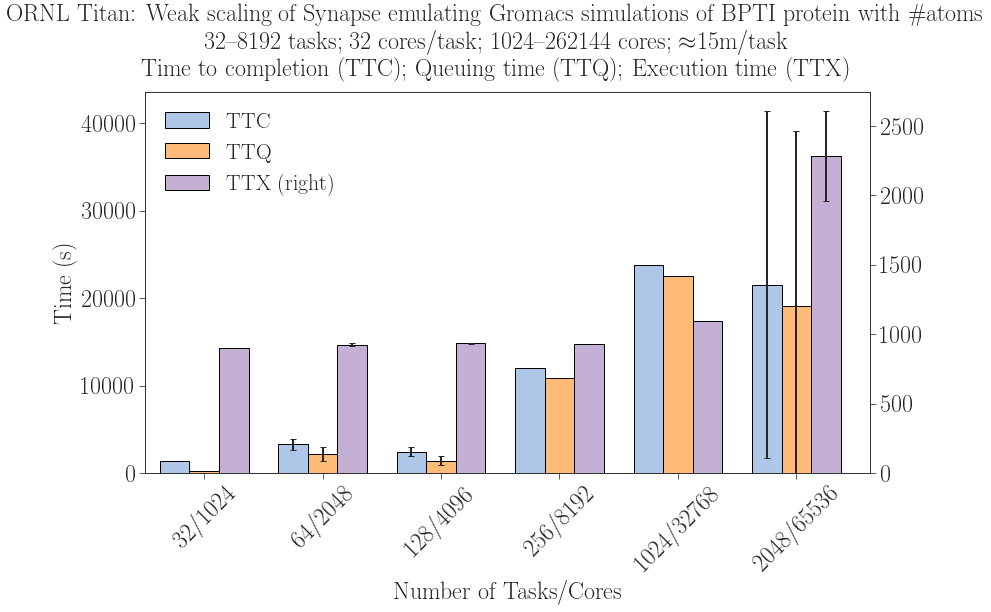

In [6]:
fig = plt.figure(figsize=(13,7))
ax = fig.add_subplot(111)  

title_head = 'ORNL Titan: Weak scaling of Synapse emulating Gromacs simulations of BPTI protein with \#atoms'
title_work = '32--8192 tasks; 32 cores/task; 1024--262144 cores; $\\approx$15m/task' 
title_desc = 'Time to completion (TTC); Queuing time (TTQ); Execution time (TTX)'
title = '%s\n%s\n%s' % (title_head, title_work, title_desc)
fig.suptitle(title, y=1.05)

# Plot means and std bars
synapse_wscaling['TTC'].reset_index().plot.bar(
    x='nunit', y='mean', yerr='std',
    position=1.5, width=0.25, color=tableau20[1], ax=ax, rot=45,
    label='TTC')

synapse_wscaling['TTQ'].reset_index().plot.bar(
    x='nunit', y='mean', yerr='std',
    position=0.5, width=0.25, color=tableau20[3], ax=ax, rot=45,
    label='TTQ')

synapse_wscaling['TTX'].reset_index().plot.bar(
    x='nunit', y='mean', yerr='std', 
    position=-0.5, width=0.25, color=tableau20[9], ax=ax, rot=45, secondary_y=True,
    label='TTX')

ax.set_xlabel('Number of Tasks/Cores')
ax.set_ylabel('Time (s)')
ax.set_ylim(0)
ax.set_xlim(-0.5)

plt.savefig('figures/titan_rp_weak_scaling.pdf', dpi=600, bbox_inches='tight')

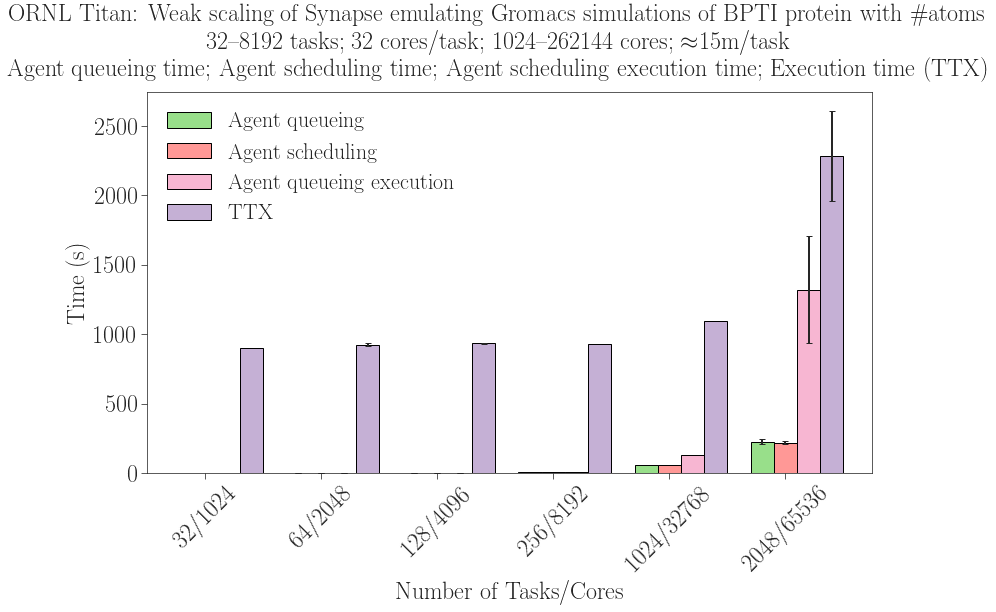

In [7]:
fig = plt.figure(figsize=(13,7))
ax = fig.add_subplot(111)  

title_head = 'ORNL Titan: Weak scaling of Synapse emulating Gromacs simulations of BPTI protein with \#atoms'
title_work = '32--8192 tasks; 32 cores/task; 1024--262144 cores; $\\approx$15m/task' 
title_desc = 'Agent queueing time; Agent scheduling time; Agent scheduling execution time; Execution time (TTX)'
title = '%s\n%s\n%s' % (title_head, title_work, title_desc)
fig.suptitle(title, y=1.05)

# Plot means and std bars
synapse_wscaling['Agent queueing'].reset_index().plot.bar(
    x='nunit', y='mean', yerr='std',
    position=1.5, width=0.20, color=tableau20[5], ax=ax, rot=45,
    label='Agent queueing')

synapse_wscaling['Agent scheduling'].reset_index().plot.bar(
    x='nunit', y='mean', yerr='std',
    position=0.5, width=0.20, color=tableau20[7], ax=ax, rot=45,
    label='Agent scheduling')

synapse_wscaling['Agent queueing execution'].reset_index().plot.bar(
    x='nunit', y='mean', yerr='std',
    position=-0.5, width=0.20, color=tableau20[13], ax=ax, rot=45,
    label='Agent queueing execution')

synapse_wscaling['TTX'].reset_index().plot.bar(
    x='nunit', y='mean', yerr='std', 
    position=-1.5, width=0.20, color=tableau20[9], ax=ax, rot=45,
    label='TTX')

ax.set_xlabel('Number of Tasks/Cores')
ax.set_ylabel('Time (s)')
ax.set_ylim(0)
ax.set_xlim(-0.5)

plt.savefig('figures/titan_agent_weak_scaling.pdf', dpi=600, bbox_inches='tight')

In [8]:
# List of events of RP
event_list = [
    # {ru.STATE: 'NEW'                          , ru.EVENT: 'state'           },
    # {ru.STATE: 'UMGR_SCHEDULING_PENDING'      , ru.EVENT: 'state'           },
    # {ru.STATE: 'UMGR_SCHEDULING'              , ru.EVENT: 'state'           },
    # {ru.STATE: 'UMGR_STAGING_INPUT_PENDING'   , ru.EVENT: 'state'           },
    # {ru.STATE: 'UMGR_STAGING_INPUT'           , ru.EVENT: 'state'           },
    # {ru.STATE: 'AGENT_STAGING_INPUT_PENDING'  , ru.EVENT: 'state'           },
    # {ru.COMP : 'agent_0'                      , ru.EVENT: 'get'             },
    # {ru.STATE: 'AGENT_STAGING_INPUT'          , ru.EVENT: 'state'           },
    # {ru.STATE: 'AGENT_SCHEDULING_PENDING'     , ru.EVENT: 'state'           },
      {ru.STATE: None                           , ru.EVENT: 'schedule_try'    }, # Scheduling start
    # {ru.STATE: 'AGENT_SCHEDULING'             , ru.EVENT: 'state'           }, 
      {ru.STATE: None                           , ru.EVENT: 'schedule_ok'     }, # Scheduling stop
      {ru.STATE: 'AGENT_EXECUTING_PENDING'      , ru.EVENT: 'state'           }, # Queuing Execution start
      {ru.STATE: 'AGENT_EXECUTING'              , ru.EVENT: 'state'           }, # Queuing Execution stop  | Preparing Execution start
      {ru.STATE: None                           , ru.EVENT: 'exec_mkdir'      }, # Creating Directory start
      {ru.STATE: None                           , ru.EVENT: 'exec_mkdir_done' }, # Creating Directory stop
      {ru.STATE: None                           , ru.EVENT: 'exec_start'      }, # Preparing Execution stop | Spawning start 
      {ru.STATE: None                           , ru.EVENT: 'exec_ok'         }, # Spawned | Execution start
      {ru.STATE: None                           , ru.EVENT: 'exec_stop'       }, # Executed
      {ru.STATE: None                           , ru.EVENT: 'unschedule_start'}, # Unscheduling start
      {ru.STATE: None                           , ru.EVENT: 'unschedule_stop' }, # Unscheduling stop
    # {ru.STATE: 'AGENT_STAGING_OUTPUT_PENDING' , ru.EVENT: 'state'           },
    # {ru.STATE: 'UMGR_STAGING_OUTPUT_PENDING'  , ru.EVENT: 'state'           },
    # {ru.STATE: 'UMGR_STAGING_OUTPUT'          , ru.EVENT: 'state'           },
    # {ru.STATE: 'AGENT_STAGING_OUTPUT'         , ru.EVENT: 'state'           },
    # {ru.STATE: 'DONE'                         , ru.EVENT: 'state'           },
]

In [9]:
# load ra session objects.
def load_sessions(sdir, sessions, snunits):
    # number of units in the sessions
    # snunits = sorted(sessions.nunit.unique().tolist())

    # load the RA session objects 
    sras = {}
    for snunit in snunits:
        sras[snunit] = []
        s = sessions[(sessions.nunit == snunit)]
        for sid in s.sid.tolist():
            exp = s.loc[sid]['experiment']
            src = '%s/%s/%s' % (sdir, exp, sid)
            sras[snunit].append(ra.Session(src, 'radical.pilot'))

    return sras

In [10]:
# Collect timestamps of all the event specified in event_list for every unit
def getdf_unit_events(session):
    s = session
    s.filter(etype='unit', inplace=True)
    data = dict()
    for thing in s.get():

        tstamps = dict()
        for event in event_list:
            eid = event[1]
            if eid == 'state': 
                eid = event[5]            
            times = thing.timestamps(event=event)
            if times: 
                tstamps[eid] = times[0]
            else: 
                tstamps[eid] = None

        data[thing.uid] = tstamps

    # We sort the entities by the timestamp of the first event
    # Also, for all timestamps, we move the baseline to the first
    # timestamp in the list
    df = pd.DataFrame.from_dict(data)
    df = df.sort_values(by=list(df.columns))
    df = df.transpose()
    df = df.reset_index()    
    
    # Rename events to make them intellegible
    df.rename_axis(                                          # Components
        {'index'                   :'uid',
         'schedule_try'            :'Started Schedule',      # Agent Scheduling Component
         'schedule_ok'             :'Scheduled',             # Agent Scheduling Component
         'AGENT_EXECUTING_PENDING' :'Queued Execution',      # Agent Executing Component
         'AGENT_EXECUTING'         :'Started Pre-Execution', # Agent Executing Component
         'exec_mkdir'              :'Started Make directory',# Agent Executing Component
         'exec_mkdir_done'         :'Made directory',        # Agent Executing Component
         'exec_start'              :'Started Spawning',      # Agent Executing Component
         'exec_ok'                 :'Started Execution',     # Agent Executing Component
         'exec_stop'               :'Executed',              # Agent Executing Component
         'unschedule_start'        :'Started Unschedule',    # Agent Scheduling Component
         'unschedule_stop'         :'Unscheduled'},          # Agent Scheduling Component
        axis='columns', inplace=True)
    
    # Durations
    df['Scheduling']          = df['Scheduled']             - df['Started Schedule']    
    df['Queuing Execution']   = df['Started Pre-Execution'] - df['Queued Execution']
    df['Preparing Execution'] = df['Started Execution']     - df['Started Pre-Execution']
    df['Making directory']    = df['Made directory']        - df['Started Make directory']
    df['Spawning']            = df['Started Execution']     - df['Started Spawning']    
    df['Executing']           = df['Executed']              - df['Started Execution']
    df['Unscheduling']        = df['Unscheduled']           - df['Started Unschedule']
    
    return df

In [11]:
# Load sessions for Synapse experiment 1
sras = load_sessions('/Users/mturilli/Projects/RADICAL/github/experiments/rp-paper-ipdps2018/analysis/data/synapse', 
                     synapse_sessions, 
                     sorted(synapse_sessions.nunit.unique().tolist()))

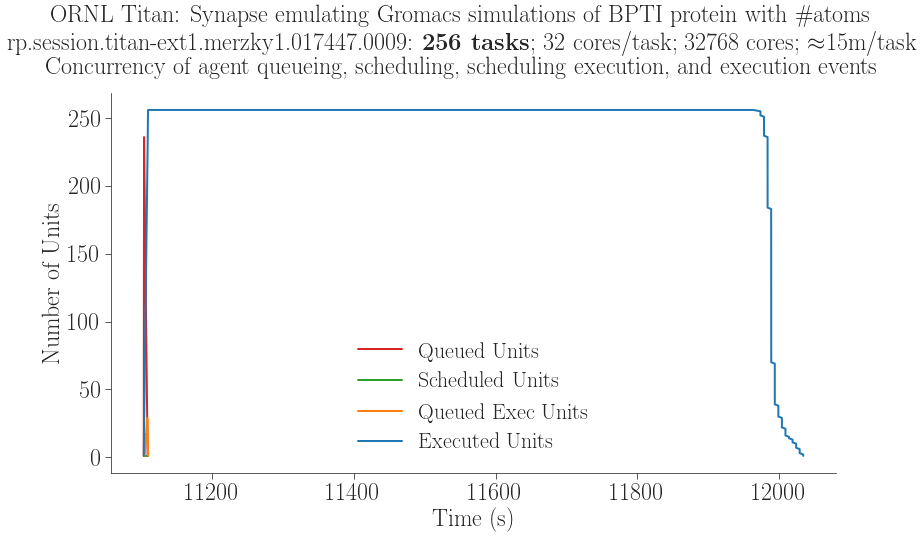

In [12]:
fig, ax = fig_setup()

title_head = 'ORNL Titan: Synapse emulating Gromacs simulations of BPTI protein with \#atoms'
title_work = '%s: \\textbf{256 tasks}; 32 cores/task; 32768 cores; $\\approx$15m/task' % sras[256][0]._sid
title_desc = 'Concurrency of agent queueing, scheduling, scheduling execution, and execution events'
title = '%s\n%s\n%s' % (title_head, title_work, title_desc)
fig.suptitle(title, y=1.05)

# Plot concurrent active units
scu = sras[256][0].concurrency(state=['AGENT_SCHEDULING_PENDING', 'AGENT_SCHEDULING'])
x = [item[0] for item in scu]
y = [item[1] for item in scu]
ax.plot(x, y, color=tableau20[6])

# Plot concurrent scheduled units
scu = sras[256][0].concurrency(state=['AGENT_SCHEDULING', 'AGENT_EXECUTING_PENDING'])
x = [item[0] for item in scu]
y = [item[1] for item in scu]
ax.plot(x, y, color=tableau20[4])

# Plot concurrent queued units
scu = sras[256][0].concurrency(state=['AGENT_EXECUTING_PENDING', 'AGENT_EXECUTING'])
x = [item[0] for item in scu]
y = [item[1] for item in scu]
ax.plot(x, y, color=tableau20[2])

# Plot concurrent active units
scu = sras[256][0].concurrency(state=['AGENT_EXECUTING', 'AGENT_STAGING_OUTPUT_PENDING'])
x = [item[0] for item in scu]
y = [item[1] for item in scu]
ax.plot(x, y, color=tableau20[0])

plt.xlabel('Time (s)')
plt.ylabel('Number of Units')
ax.legend(labels=['Queued Units', 'Scheduled Units', 'Queued Exec Units', 'Executed Units'])

plt.savefig('figures/titan_agent_concurrency_256.pdf', dpi=600, bbox_inches='tight')

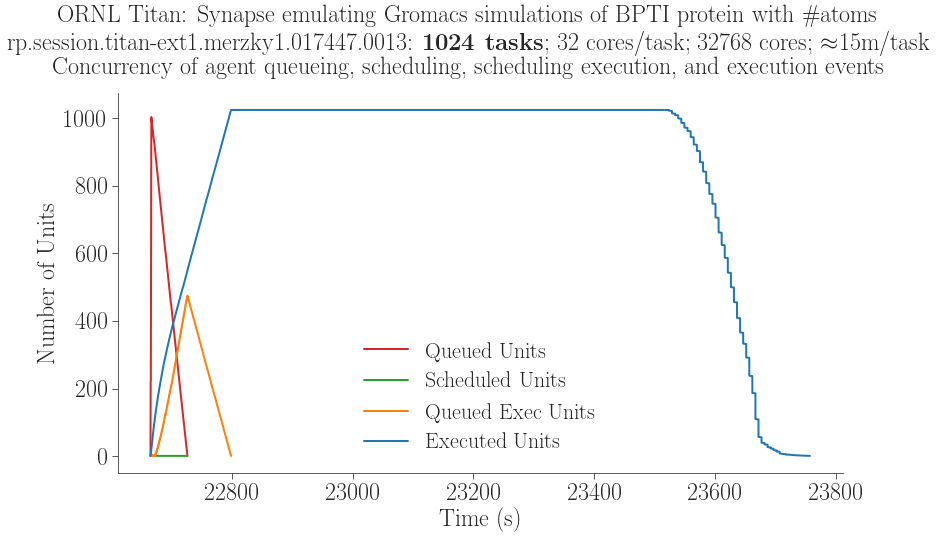

In [13]:
fig, ax = fig_setup()

title_head = 'ORNL Titan: Synapse emulating Gromacs simulations of BPTI protein with \#atoms'
title_work = '%s: \\textbf{1024 tasks}; 32 cores/task; 32768 cores; $\\approx$15m/task' % sras[1024][0]._sid
title_desc = 'Concurrency of agent queueing, scheduling, scheduling execution, and execution events'
title = '%s\n%s\n%s' % (title_head, title_work, title_desc)
fig.suptitle(title, y=1.05)

# Plot concurrent active units
scu = sras[1024][0].concurrency(state=['AGENT_SCHEDULING_PENDING', 'AGENT_SCHEDULING'])
x = [item[0] for item in scu]
y = [item[1] for item in scu]
ax.plot(x, y, color=tableau20[6])

# Plot concurrent scheduled units
scu = sras[1024][0].concurrency(state=['AGENT_SCHEDULING', 'AGENT_EXECUTING_PENDING'])
x = [item[0] for item in scu]
y = [item[1] for item in scu]
ax.plot(x, y, color=tableau20[4])

# Plot concurrent queued units
scu = sras[1024][0].concurrency(state=['AGENT_EXECUTING_PENDING', 'AGENT_EXECUTING'])
x = [item[0] for item in scu]
y = [item[1] for item in scu]
ax.plot(x, y, color=tableau20[2])

# Plot concurrent active units
scu = sras[1024][0].concurrency(state=['AGENT_EXECUTING', 'AGENT_STAGING_OUTPUT_PENDING'])
x = [item[0] for item in scu]
y = [item[1] for item in scu]
ax.plot(x, y, color=tableau20[0])

plt.xlabel('Time (s)')
plt.ylabel('Number of Units')
ax.legend(labels=['Queued Units', 'Scheduled Units', 'Queued Exec Units', 'Executed Units'])

plt.savefig('figures/titan_agent_concurrency_1024.pdf', dpi=600, bbox_inches='tight')

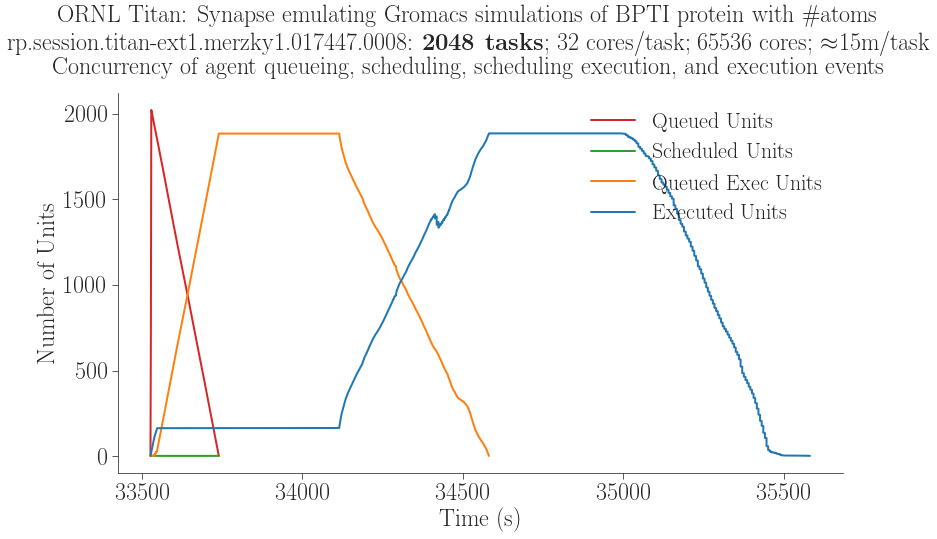

In [14]:
fig, ax = fig_setup()

title_head = 'ORNL Titan: Synapse emulating Gromacs simulations of BPTI protein with \#atoms'
title_work = '%s: \\textbf{2048 tasks}; 32 cores/task; 65536 cores; $\\approx$15m/task' % sras[2048][0]._sid
title_desc = 'Concurrency of agent queueing, scheduling, scheduling execution, and execution events'
title = '%s\n%s\n%s' % (title_head, title_work, title_desc)
fig.suptitle(title, y=1.05)

# Plot concurrent active units
scu = sras[2048][0].concurrency(state=['AGENT_SCHEDULING_PENDING', 'AGENT_SCHEDULING'])
x = [item[0] for item in scu]
y = [item[1] for item in scu]
ax.plot(x, y, color=tableau20[6])

# Plot concurrent scheduled units
scu = sras[2048][0].concurrency(state=['AGENT_SCHEDULING', 'AGENT_EXECUTING_PENDING'])
x = [item[0] for item in scu]
y = [item[1] for item in scu]
ax.plot(x, y, color=tableau20[4])

# Plot concurrent queued units
scu = sras[2048][0].concurrency(state=['AGENT_EXECUTING_PENDING', 'AGENT_EXECUTING'])
x = [item[0] for item in scu]
y = [item[1] for item in scu]
ax.plot(x, y, color=tableau20[2])

# Plot concurrent active units
scu = sras[2048][0].concurrency(state=['AGENT_EXECUTING', 'AGENT_STAGING_OUTPUT_PENDING'])
x = [item[0] for item in scu]
y = [item[1] for item in scu]
ax.plot(x, y, color=tableau20[0])

plt.xlabel('Time (s)')
plt.ylabel('Number of Units')
ax.legend(labels=['Queued Units', 'Scheduled Units', 'Queued Exec Units', 'Executed Units'])

plt.savefig('figures/titan_agent_concurrency_2048_a.pdf', dpi=600, bbox_inches='tight')

# Starting to use events

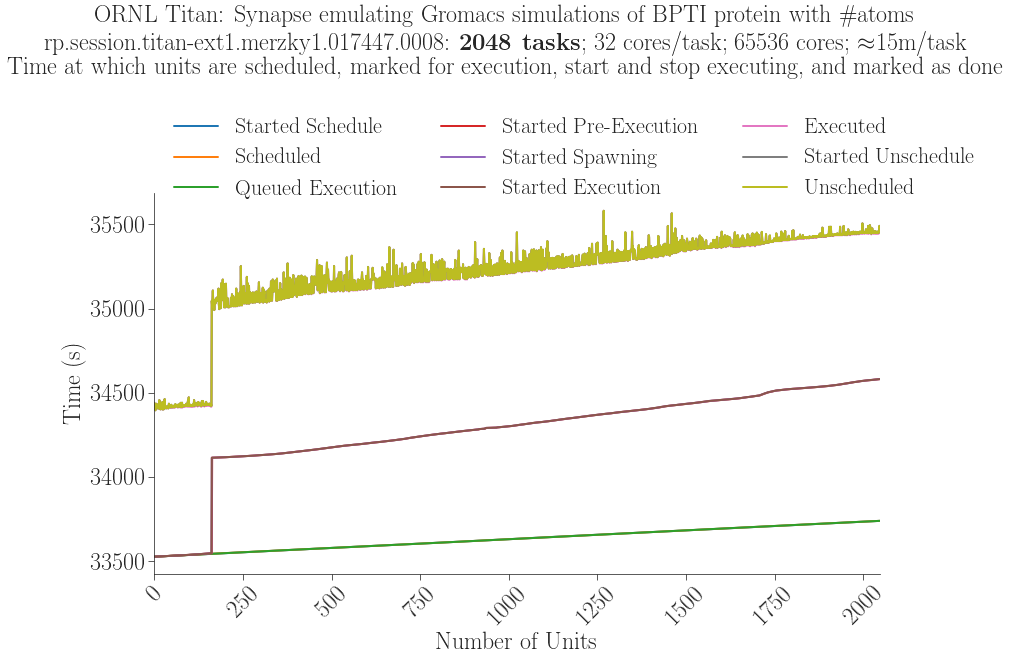

In [15]:
session = sras[2048][0]
fig, ax = fig_setup()

title_head = 'ORNL Titan: Synapse emulating Gromacs simulations of BPTI protein with \#atoms'
title_work = '%s: \\textbf{2048 tasks}; 32 cores/task; 65536 cores; $\\approx$15m/task' % session._sid
title_desc = 'Time at which units are scheduled, marked for execution, start and stop executing, and marked as done'
title = '%s\n%s\n%s' % (title_head, title_work, title_desc)
fig.suptitle(title, y=1.25)

# Get events and order them by Scheduling
df = getdf_unit_events(session)
df = df.sort_values(by='Scheduled')
df = df.reset_index(drop=True)

timestamps = df[['Started Schedule','Scheduled',
                 'Queued Execution', 
                 'Started Pre-Execution',
                 'Started Spawning',
                 'Started Execution', 'Executed', 
                 'Started Unschedule', 'Unscheduled']]

timestamps.plot(ax=ax, rot=45)

plt.legend(ncol=3, loc='upper left', bbox_to_anchor=(0,1.25))
plt.xlabel('Number of Units')
plt.ylabel('Time (s)')

plt.savefig('figures/titan_unit_events_2048.pdf', dpi=600, bbox_inches='tight')

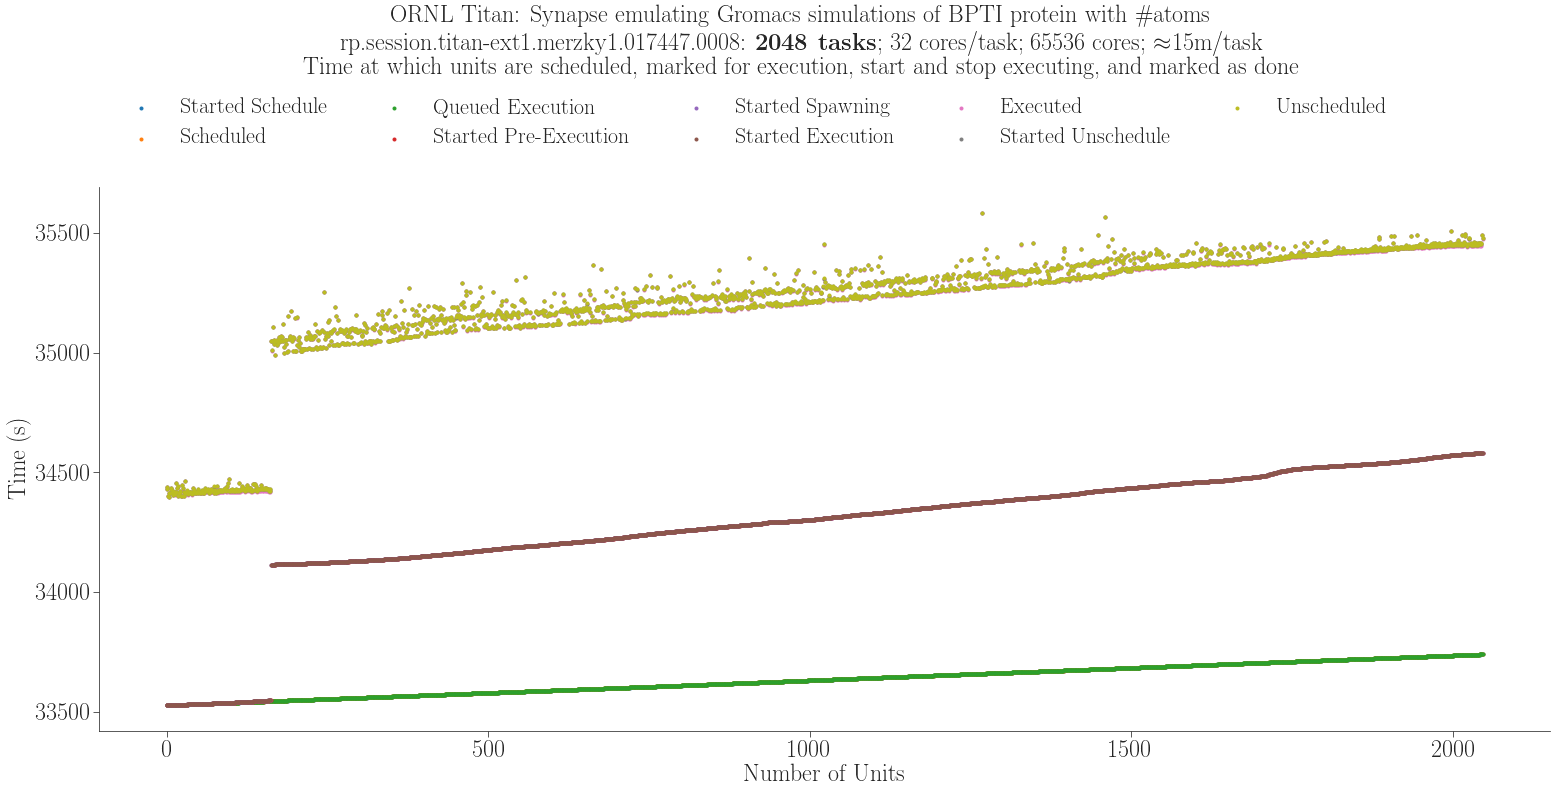

In [16]:
session = sras[2048][0]
fig = plt.figure(figsize=(26,10))
ax = fig.add_subplot(111)  
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)  
ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left()

title_head = 'ORNL Titan: Synapse emulating Gromacs simulations of BPTI protein with \#atoms'
title_work = '%s: \\textbf{2048 tasks}; 32 cores/task; 65536 cores; $\\approx$15m/task' % session._sid
title_desc = 'Time at which units are scheduled, marked for execution, start and stop executing, and marked as done'
title = '%s\n%s\n%s' % (title_head, title_work, title_desc)
fig.suptitle(title, y=1.13)

# Get events and order them by Scheduling
df = getdf_unit_events(session)
df = df.sort_values(by='Scheduled')
df = df.reset_index(drop=True)

plt.scatter(df['Started Schedule'].index     , df['Started Schedule']     , marker='.')
plt.scatter(df['Scheduled'].index            , df['Scheduled']            , marker='.')
plt.scatter(df['Queued Execution'].index     , df['Queued Execution']     , marker='.')
plt.scatter(df['Started Pre-Execution'].index, df['Started Pre-Execution'], marker='.')
plt.scatter(df['Started Spawning'].index     , df['Started Spawning']     , marker='.')
plt.scatter(df['Started Execution'].index    , df['Started Execution']    , marker='.')
plt.scatter(df['Executed'].index             ,  df['Executed']            , marker='.')
plt.scatter(df['Started Unschedule'].index   , df['Started Unschedule']   , marker='.')
plt.scatter(df['Unscheduled'].index          , df['Unscheduled']          , marker='.')

plt.legend(ncol=5, loc='upper left', bbox_to_anchor=(0,1.2))
plt.xlabel('Number of Units')
plt.ylabel('Time (s)')

# plt.savefig('figures/titan_unit_events_2048_b.pdf', dpi=600, bbox_inches='tight')

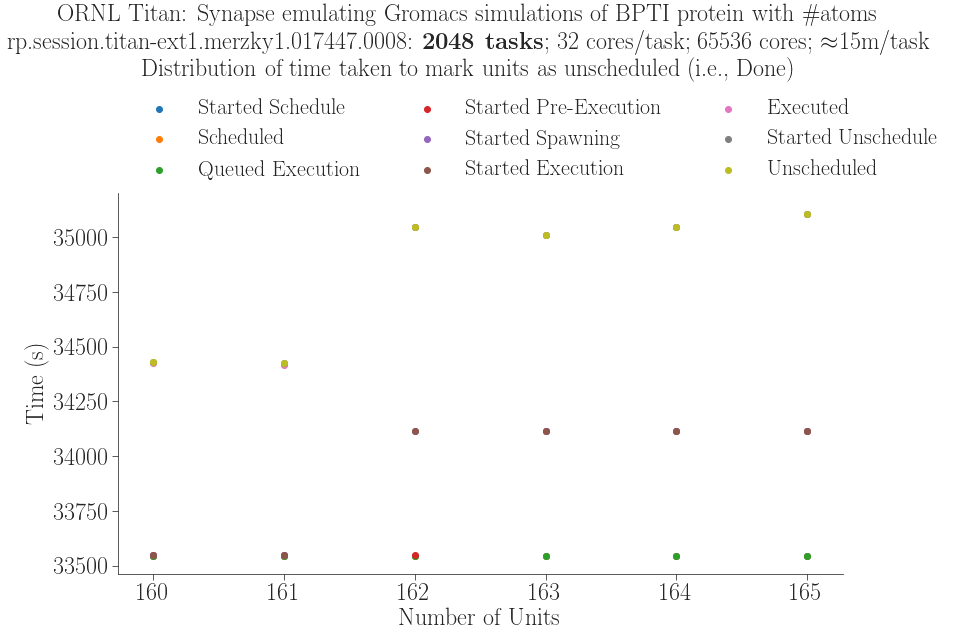

In [17]:
session = sras[2048][0]
fig, ax = fig_setup()

title_head = 'ORNL Titan: Synapse emulating Gromacs simulations of BPTI protein with \#atoms'
title_work = '%s: \\textbf{2048 tasks}; 32 cores/task; 65536 cores; $\\approx$15m/task' % session._sid
title_desc = 'Distribution of time taken to mark units as unscheduled (i.e., Done)'
title = '%s\n%s\n%s' % (title_head, title_work, title_desc)
fig.suptitle(title, y=1.25)

# Get events and order them by Scheduling
df = getdf_unit_events(session)
df = df.sort_values(by='Scheduled')
df = df.reset_index(drop=True)

df = df.iloc[160:166]

plt.scatter(df['Started Schedule'].index     , df['Started Schedule']     )
plt.scatter(df['Scheduled'].index            , df['Scheduled']            )
plt.scatter(df['Queued Execution'].index     , df['Queued Execution']     )
plt.scatter(df['Started Pre-Execution'].index, df['Started Pre-Execution'])
plt.scatter(df['Started Spawning'].index     , df['Started Spawning']     )
plt.scatter(df['Started Execution'].index    , df['Started Execution']    )
plt.scatter(df['Executed'].index             ,  df['Executed']            )
plt.scatter(df['Started Unschedule'].index   , df['Started Unschedule']   )
plt.scatter(df['Unscheduled'].index          , df['Unscheduled']          )

plt.legend(ncol=3, loc='upper left', bbox_to_anchor=(0,1.3))
plt.xlabel('Number of Units')
plt.ylabel('Time (s)')

# plt.savefig('figures/titan_unit_events_2048_b.pdf', dpi=600, bbox_inches='tight')

In [18]:
session = sras[2048][0]
# Get events and order them by Scheduling
df = getdf_unit_events(session)
df = df.sort_values(by='Scheduled')
df = df.reset_index(drop=True)

df.iloc[160:166][[
    'uid', 
#   'Started Schedule',
#   'Scheduled',
    'Queuing Execution',
    'Preparing Execution',
    'Queued Execution',
    'Making directory',
    'Spawning',
    'Executing',
    'Unscheduling'
#   'Started Pre-Execution',
#   'Started Make directory',
#   'Made directory',
#   'Started Spawning',
#   'Started Execution',
#   'Executed',
#   'Started Unschedule',
#   'Unscheduled'
    ]]

,uid,Queuing Execution,Preparing Execution,Queued Execution,Making directory,Spawning,Executing,Unscheduling
160,unit.000876,3.5214,0.1915,33543.5462,NaN,0.0157,876.7046,0.0388
161,unit.000087,3.6071,0.2021,33543.6534,NaN,0.0072,870.7144,0.0323
162,unit.000878,3.4821,567.0722,33543.9819,NaN,0.0077,931.9057,0.0395
163,unit.000088,570.4473,0.0588,33544.0906,NaN,0.0076,893.5165,0.0315
164,unit.000880,570.4066,0.0142,33544.1916,NaN,0.0072,932.0327,0.0318
165,unit.000089,570.3225,0.0166,33544.2912,NaN,0.0076,993.0579,0.0366


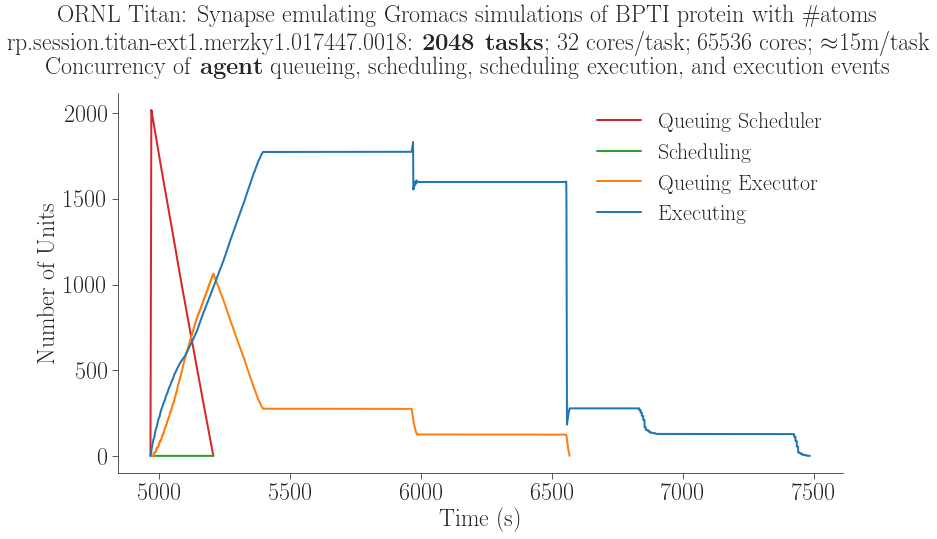

In [19]:
fig, ax = fig_setup()

title_head = 'ORNL Titan: Synapse emulating Gromacs simulations of BPTI protein with \#atoms'
title_work = '%s: \\textbf{2048 tasks}; 32 cores/task; 65536 cores; $\\approx$15m/task' % sras[2048][1]._sid
title_desc = 'Concurrency of \\textbf{agent} queueing, scheduling, scheduling execution, and execution events'
title = '%s\n%s\n%s' % (title_head, title_work, title_desc)
fig.suptitle(title, y=1.05)

# Queuing Scheduler
scu = sras[2048][1].concurrency(state=['AGENT_SCHEDULING_PENDING', 'AGENT_SCHEDULING'])
x = [item[0] for item in scu]
y = [item[1] for item in scu]
ax.plot(x, y, color=tableau20[6])

# Scheduling
scu = sras[2048][1].concurrency(state=['AGENT_SCHEDULING', 'AGENT_EXECUTING_PENDING'])
x = [item[0] for item in scu]
y = [item[1] for item in scu]
ax.plot(x, y, color=tableau20[4])

# Queuing Executor
scu = sras[2048][1].concurrency(state=['AGENT_EXECUTING_PENDING', 'AGENT_EXECUTING'])
x = [item[0] for item in scu]
y = [item[1] for item in scu]
ax.plot(x, y, color=tableau20[2])

# Executing
scu = sras[2048][1].concurrency(state=['AGENT_EXECUTING', 'AGENT_STAGING_OUTPUT_PENDING'])
x = [item[0] for item in scu]
y = [item[1] for item in scu]
ax.plot(x, y, color=tableau20[0])

plt.xlabel('Time (s)')
plt.ylabel('Number of Units')
ax.legend(labels=['Queuing Scheduler', 'Scheduling', 'Queuing Executor', 'Executing'])

plt.savefig('figures/titan_agent_concurrency_2048_b.pdf', dpi=600, bbox_inches='tight')

# Naming

## Durations in the Agent

| Event Pair                                                                           | Duration          | Component    | Entity | Relation | Name               | Description                                               |
|--------------------------------------------------------------------------------------|-------------------|--------------|--------|----------|--------------------|-----------------------------------------------------------|
|                                                                                      | Queuing           | Stager       | file   | unit     | Queuing Stager In  | Time spent by a unit's input file queuing into the Stager |
|                                                                                      | Staging           | Stager       | file   | unit     | Staging In         | Time spent ataging a unit's input file                    |
| ['AGENT_SCHEDULING_PENDING', 'AGENT_SCHEDULING']                                     | Qeuing            | Scheduler    | unit   | -        | Qeuing Scheduler   | Time spent by a unit queuing into the Scheduler           |
| [{ru.EVENT: 'state', ru.STATE: 'AGENT_SCHEDULING'}, {ru.EVENT: 'schedule_ok'}]       | Scheduling        | Scheduler    | unit   | -        | Scheduling         | Time spent scheduling a unit                              |
| [{ru.EVENT: 'state', ru.STATE: 'AGENT_EXECUTING_PENDING'}, {ru.EVENT: 'exec_start'}] | Queuing           | Executor     | unit   | -        | Queuing Executor   | Time spent by a unit queuing into the Executor            |
|                                                                                      | Spawning          | Executor     | unit   | -        | Spawning           | Time spent spawning a unit                                |
| [{ru.EVENT: 'exec_start'}, {ru.EVENT: 'exec_stop'}]                                  | Executing         | Executor     | unit   | -        | Executing          | Time spent executing a unit                               |
| [{ru.EVENT: 'exec_stop'}, {ru.EVENT: 'unschedule_stop'}]                             | Unscheduling      | Scheduler    | unit   | -        | Unscheduling       | Time taken unscheduling a unit                            |
|                                                                                      | Queuing           | Stager       | file   | unit     | Queuing Stager Out | Time spent by a unit's output file qeuing into the Stager |
|                                                                                      | Staging           | Stager       | file   | unit     | Staging Out        | Time spent staging a unit's output file                   |


## Unit Events in the Agent


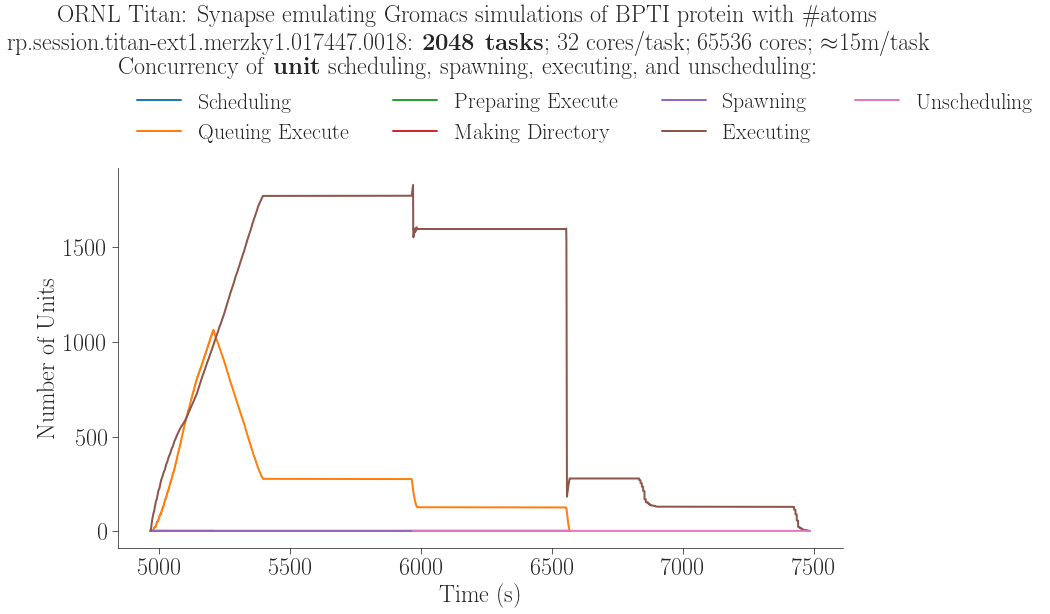

In [20]:
fig, ax = fig_setup()
session = sras[2048][1]

title_head = 'ORNL Titan: Synapse emulating Gromacs simulations of BPTI protein with \#atoms'
title_work = '%s: \\textbf{2048 tasks}; 32 cores/task; 65536 cores; $\\approx$15m/task' % sras[2048][1]._sid
title_desc = 'Concurrency of \\textbf{unit} scheduling, spawning, executing, and unscheduling:  '
title = '%s\n%s\n%s' % (title_head, title_work, title_desc)
fig.suptitle(title, y=1.2)

# How many units are being scheduled
scu = session.concurrency(event=[
 {ru.STATE: None, ru.EVENT: 'schedule_try'},               # Scheduling start
 {ru.STATE: None, ru.EVENT: 'schedule_ok'}])               # Scheduling stop
x = [item[0] for item in scu]
y = [item[1] for item in scu]
ax.plot(x, y) #, color=tableau20[6])

# How many units are being queued for execution
scu = session.concurrency(event=[
 {ru.STATE: 'AGENT_EXECUTING_PENDING', ru.EVENT: 'state'}, # Queuing Execution start
 {ru.STATE: 'AGENT_EXECUTING', ru.EVENT: 'state'}])        # Queuing Execution stop  
x = [item[0] for item in scu]
y = [item[1] for item in scu]
ax.plot(x, y) #, color=tableau20[4])

# How many units are being prepared for execution
scu = session.concurrency(event=[
 {ru.STATE: 'AGENT_EXECUTING', ru.EVENT: 'state'},         # Preparing Execution start
 {ru.STATE: None, ru.EVENT: 'exec_start'}])                # Preparing Execution stop
x = [item[0] for item in scu]
y = [item[1] for item in scu]
ax.plot(x, y) #, color=tableau20[12])

# How many units are being held while their directories are being created
scu = session.concurrency(event=[
 {ru.STATE: None, ru.EVENT: 'exec_mkdir'},                 # Creating Directory start
 {ru.STATE: None, ru.EVENT: 'exec_mkdir_done'}])           # Creating Directory stop
x = [item[0] for item in scu]
y = [item[1] for item in scu]
ax.plot(x, y) #, color=tableau20[14])

# How many units are being spawned
scu = session.concurrency(event=[
 {ru.STATE: None, ru.EVENT: 'exec_start'},                 # Spawning start 
 {ru.STATE: None, ru.EVENT: 'exec_ok'}])                   # Spawned
x = [item[0] for item in scu]
y = [item[1] for item in scu]
ax.plot(x, y) #, color=tableau20[0])

# How many units are being executed
scu = session.concurrency(event=[
 {ru.STATE: None, ru.EVENT: 'exec_ok'},                    # Execution start
 {ru.STATE: None, ru.EVENT: 'exec_stop'}])                 # Executed
x = [item[0] for item in scu]
y = [item[1] for item in scu]
ax.plot(x, y) #, color=tableau20[0])

# How many units are being unscheduled
scu = session.concurrency(event=[
 {ru.STATE: None, ru.EVENT: 'unschedule_start'},           # Unscheduling start
 {ru.STATE: None, ru.EVENT: 'unschedule_stop'}])           # Unscheduling stop
x = [item[0] for item in scu]
y = [item[1] for item in scu]
ax.plot(x, y) #, color=tableau20[8])

ax.legend(ncol=4, loc='upper left', bbox_to_anchor=(0,1.25),
          labels=['Scheduling', 'Queuing Execute', 'Preparing Execute', 
                  'Making Directory', 'Spawning', 'Executing', 'Unscheduling'])
plt.xlabel('Time (s)')
plt.ylabel('Number of Units')

#plt.savefig('figures/titan_agent_concurrency_2048_b.pdf', dpi=600, bbox_inches='tight')

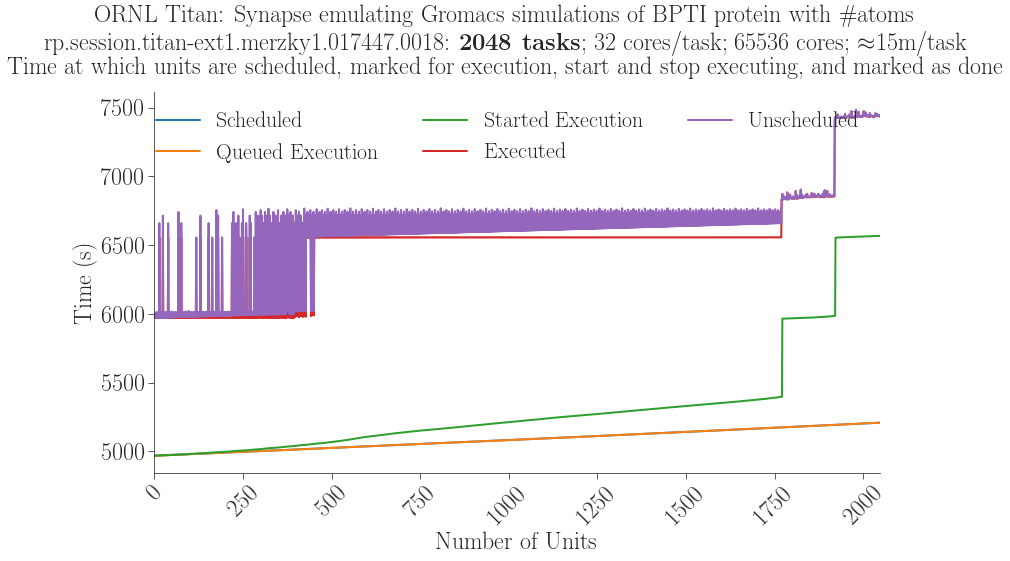

In [21]:
session = sras[2048][1]
fig, ax = fig_setup()

title_head = 'ORNL Titan: Synapse emulating Gromacs simulations of BPTI protein with \#atoms'
title_work = '%s: \\textbf{2048 tasks}; 32 cores/task; 65536 cores; $\\approx$15m/task' % session._sid
title_desc = 'Time at which units are scheduled, marked for execution, start and stop executing, and marked as done'
title = '%s\n%s\n%s' % (title_head, title_work, title_desc)
fig.suptitle(title, y=1.05)

# Get events and order them by Scheduling
df = getdf_unit_events(session)
df = df.sort_values(by='Scheduled')
df = df.reset_index(drop=True)

timestamps = df[['Scheduled','Queued Execution', 'Started Execution', 'Executed', 'Unscheduled']]

timestamps.plot(ax=ax, rot=45)

plt.legend(ncol=3)
plt.xlabel('Number of Units')
plt.ylabel('Time (s)')

plt.savefig('figures/titan_unit_events_2048_b.pdf', dpi=600, bbox_inches='tight')

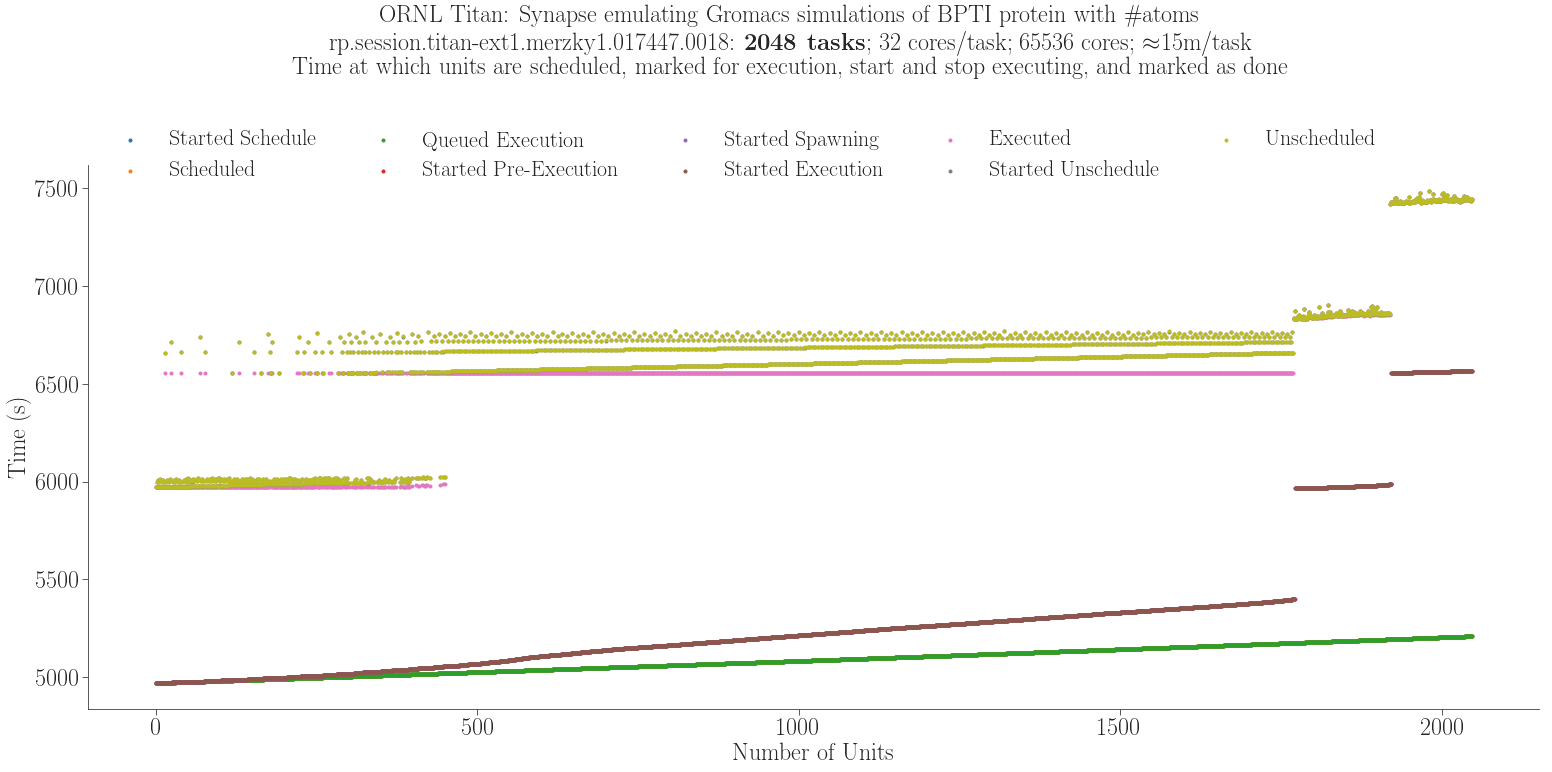

In [22]:
session = sras[2048][1]
fig = plt.figure(figsize=(26,10))
ax = fig.add_subplot(111)  
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)  
ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left()

title_head = 'ORNL Titan: Synapse emulating Gromacs simulations of BPTI protein with \#atoms'
title_work = '%s: \\textbf{2048 tasks}; 32 cores/task; 65536 cores; $\\approx$15m/task' % session._sid
title_desc = 'Time at which units are scheduled, marked for execution, start and stop executing, and marked as done'
title = '%s\n%s\n%s' % (title_head, title_work, title_desc)
fig.suptitle(title, y=1.1)

# Get events and order them by Scheduling
df = getdf_unit_events(session)
df = df.sort_values(by='Scheduled')
df = df.reset_index(drop=True)

plt.scatter(df['Started Schedule'].index     , df['Started Schedule']     , marker='.')
plt.scatter(df['Scheduled'].index            , df['Scheduled']            , marker='.')
plt.scatter(df['Queued Execution'].index     , df['Queued Execution']     , marker='.')
plt.scatter(df['Started Pre-Execution'].index, df['Started Pre-Execution'], marker='.')
plt.scatter(df['Started Spawning'].index     , df['Started Spawning']     , marker='.')
plt.scatter(df['Started Execution'].index    , df['Started Execution']    , marker='.')
plt.scatter(df['Executed'].index             , df['Executed']             , marker='.')
plt.scatter(df['Started Unschedule'].index   , df['Started Unschedule']   , marker='.')
plt.scatter(df['Unscheduled'].index          , df['Unscheduled']          , marker='.')

plt.legend(ncol=5, loc='upper left', bbox_to_anchor=(0,1.1))
plt.xlabel('Number of Units')
plt.ylabel('Time (s)')

# plt.savefig('figures/titan_unit_events_2048_b.pdf', dpi=600, bbox_inches='tight')

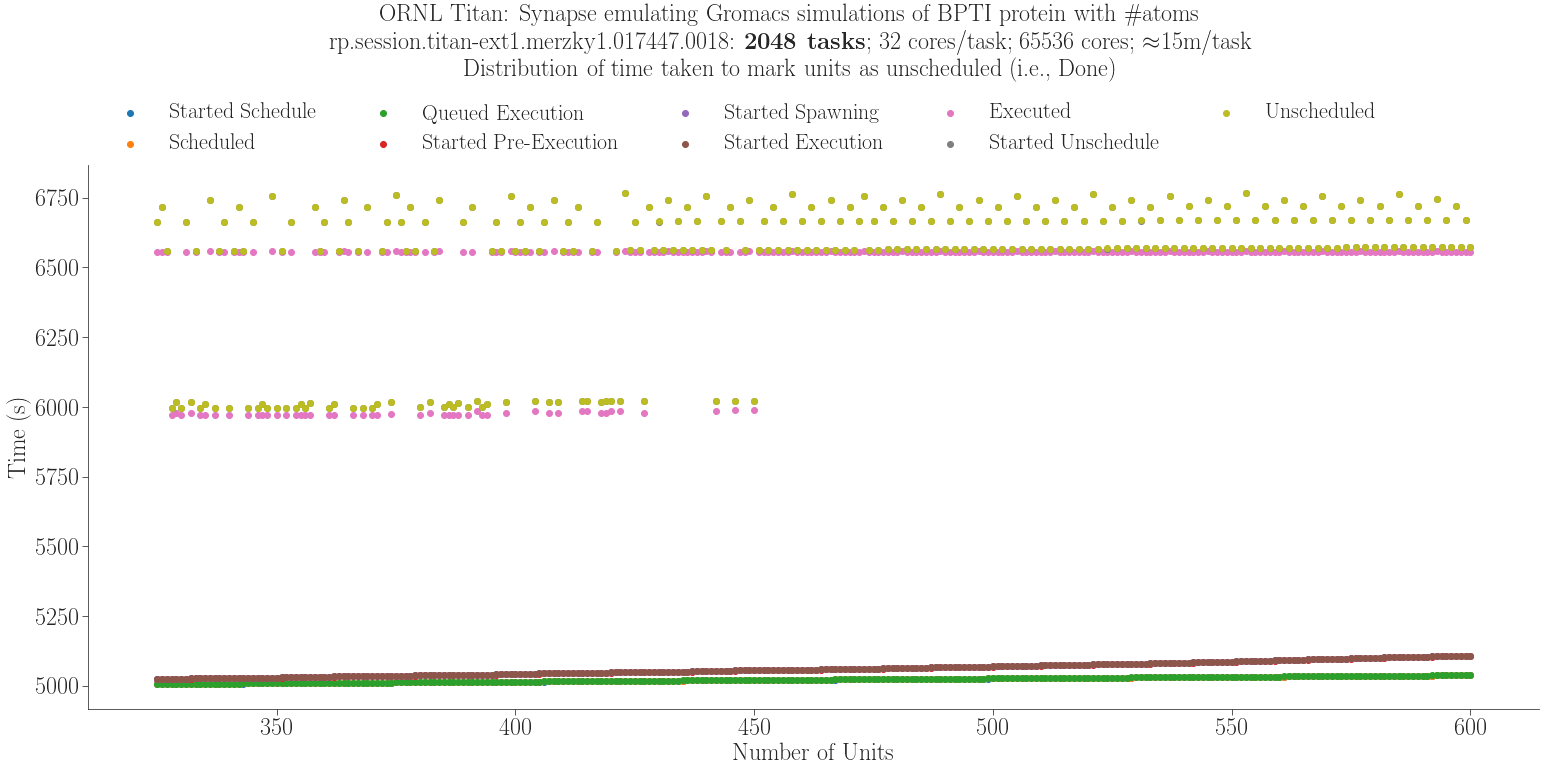

In [23]:
session = sras[2048][1]
fig = plt.figure(figsize=(26,10))
ax = fig.add_subplot(111)  
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)  
ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left()

title_head = 'ORNL Titan: Synapse emulating Gromacs simulations of BPTI protein with \#atoms'
title_work = '%s: \\textbf{2048 tasks}; 32 cores/task; 65536 cores; $\\approx$15m/task' % session._sid
title_desc = 'Distribution of time taken to mark units as unscheduled (i.e., Done)'
title = '%s\n%s\n%s' % (title_head, title_work, title_desc)
fig.suptitle(title, y=1.1)

# Get events and order them by Scheduling
df = getdf_unit_events(session)
df = df.sort_values(by='Scheduled')
df = df.reset_index(drop=True)

df = df.iloc[325:601]

plt.scatter(df['Started Schedule'].index     , df['Started Schedule']     )
plt.scatter(df['Scheduled'].index            , df['Scheduled']            )
plt.scatter(df['Queued Execution'].index     , df['Queued Execution']     )
plt.scatter(df['Started Pre-Execution'].index, df['Started Pre-Execution'])
plt.scatter(df['Started Spawning'].index     , df['Started Spawning']     )
plt.scatter(df['Started Execution'].index    , df['Started Execution']    )
plt.scatter(df['Executed'].index             , df['Executed']             )
plt.scatter(df['Started Unschedule'].index   , df['Started Unschedule']   )
plt.scatter(df['Unscheduled'].index          , df['Unscheduled']          )

plt.legend(ncol=5, loc='upper left', bbox_to_anchor=(0,1.15))
plt.xlabel('Number of Units')
plt.ylabel('Time (s)')

# plt.savefig('figures/titan_unit_events_2048_b.pdf', dpi=600, bbox_inches='tight')

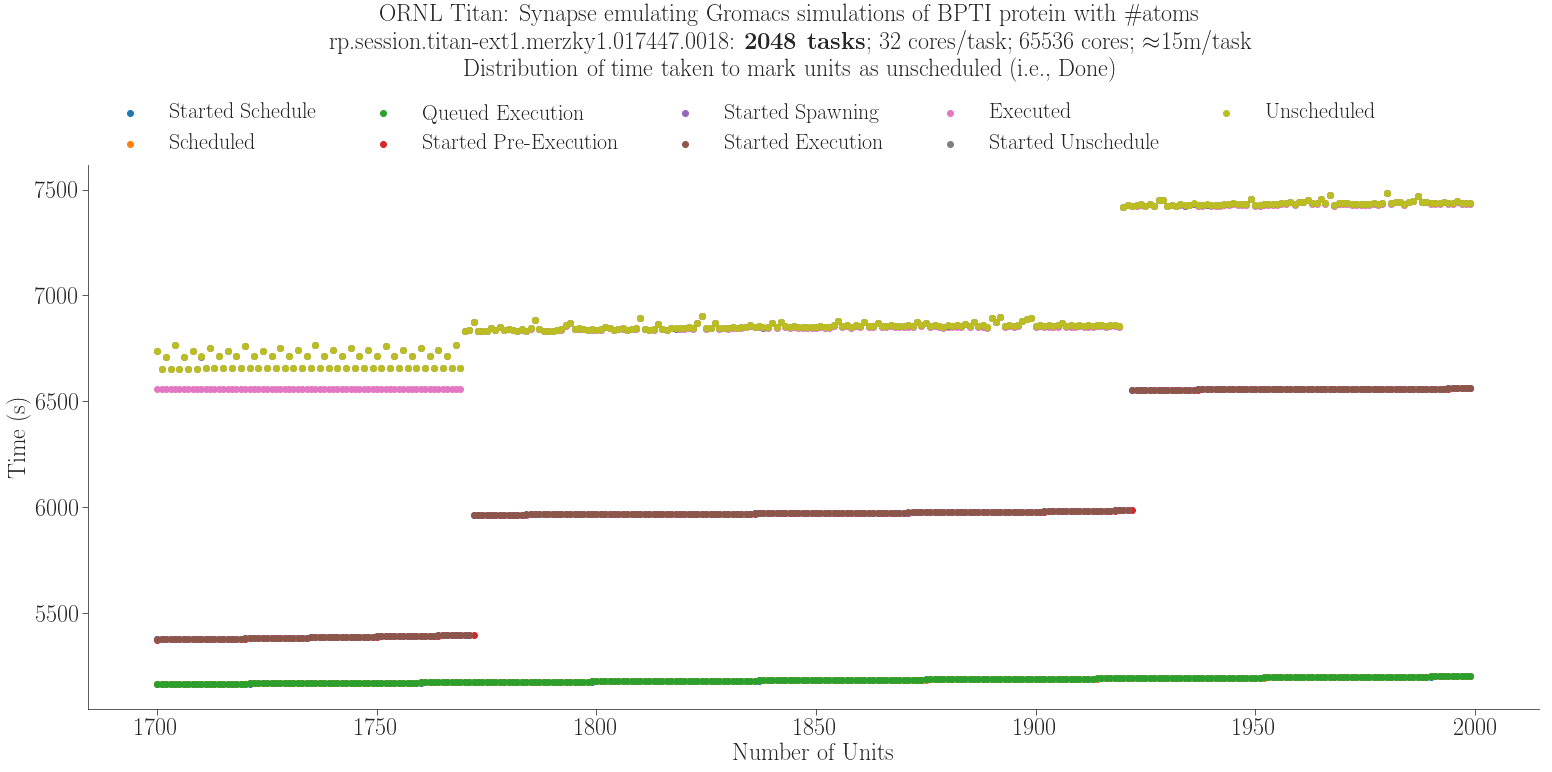

In [24]:
session = sras[2048][1]
fig = plt.figure(figsize=(26,10))
ax = fig.add_subplot(111)  
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)  
ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left()

title_head = 'ORNL Titan: Synapse emulating Gromacs simulations of BPTI protein with \#atoms'
title_work = '%s: \\textbf{2048 tasks}; 32 cores/task; 65536 cores; $\\approx$15m/task' % session._sid
title_desc = 'Distribution of time taken to mark units as unscheduled (i.e., Done)'
title = '%s\n%s\n%s' % (title_head, title_work, title_desc)
fig.suptitle(title, y=1.1)

# Get events and order them by Scheduling
df = getdf_unit_events(session)
df = df.sort_values(by='Scheduled')
df = df.reset_index(drop=True)

# Slice df to isolate different execution time
df = df.iloc[1700:2000]

plt.scatter(df['Started Schedule'].index     , df['Started Schedule']     )
plt.scatter(df['Scheduled'].index            , df['Scheduled']            )
plt.scatter(df['Queued Execution'].index     , df['Queued Execution']     )
plt.scatter(df['Started Pre-Execution'].index, df['Started Pre-Execution'])
plt.scatter(df['Started Spawning'].index     , df['Started Spawning']     )
plt.scatter(df['Started Execution'].index    , df['Started Execution']    )
plt.scatter(df['Executed'].index             , df['Executed']             )
plt.scatter(df['Started Unschedule'].index   , df['Started Unschedule']   )
plt.scatter(df['Unscheduled'].index          , df['Unscheduled']          )

plt.legend(ncol=5, loc='upper left', bbox_to_anchor=(0,1.15))
plt.xlabel('Number of Units')
plt.ylabel('Time (s)')

# plt.savefig('figures/titan_unit_events_2048_b.pdf', dpi=600, bbox_inches='tight')

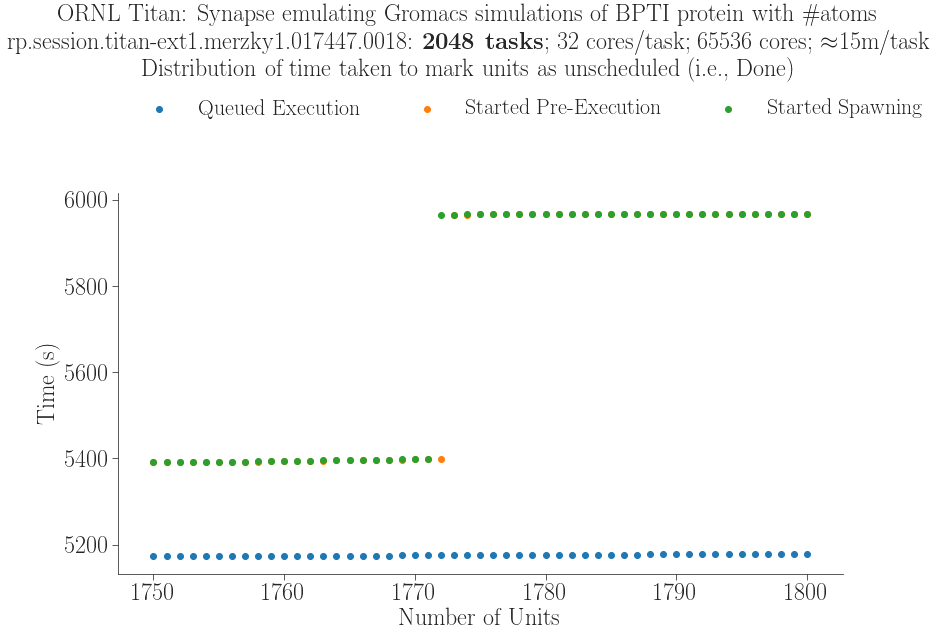

In [25]:
session = sras[2048][1]
fig, ax = fig_setup()

title_head = 'ORNL Titan: Synapse emulating Gromacs simulations of BPTI protein with \#atoms'
title_work = '%s: \\textbf{2048 tasks}; 32 cores/task; 65536 cores; $\\approx$15m/task' % session._sid
title_desc = 'Distribution of time taken to mark units as unscheduled (i.e., Done)'
title = '%s\n%s\n%s' % (title_head, title_work, title_desc)
fig.suptitle(title, y=1.25)

# Get events and order them by Scheduling
df = getdf_unit_events(session)
df = df.sort_values(by='Scheduled')
df = df.reset_index(drop=True)

df = df.iloc[1750:1801]

# plt.scatter(df['Started Schedule'].index     , df['Started Schedule']     )
# plt.scatter(df['Scheduled'].index            , df['Scheduled']            )
plt.scatter(df['Queued Execution'].index     , df['Queued Execution']     )
plt.scatter(df['Started Pre-Execution'].index, df['Started Pre-Execution'])
plt.scatter(df['Started Spawning'].index     , df['Started Spawning']     )
# plt.scatter(df['Started Execution'].index    , df['Started Execution']    )
# plt.scatter(df['Executed'].index             , df['Executed']             )
# plt.scatter(df['Started Unschedule'].index   , df['Started Unschedule']   )
# plt.scatter(df['Unscheduled'].index          , df['Unscheduled']          )

plt.legend(ncol=3, loc='upper left', bbox_to_anchor=(0,1.3))
plt.xlabel('Number of Units')
plt.ylabel('Time (s)')

# plt.savefig('figures/titan_unit_events_2048_b.pdf', dpi=600, bbox_inches='tight')

Note: Spawning+Executing time does not change significantly between unit 1566-67 and 1568-71. Is this suggesting that OpenMPI returns the event Start Execution to RP with variable delay?

In [26]:
session = sras[2048][1]
# Get events and order them by Scheduling
df = getdf_unit_events(session)
df = df.sort_values(by='Scheduled')
df = df.reset_index(drop=True)
df.iloc[1750:1801][[
    'uid', 
    'Queuing Execution',
    'Preparing Execution',
    'Making directory',
    'Spawning',
    'Executing',
    'Unscheduling'
#   'Started Schedule',
#   'Scheduled',
#   'Queued Execution',
#   'Started Pre-Execution',
#   'Started Make directory',
#   'Made directory',
#   'Started Spawning',
#   'Started Execution',
#   'Executed',
#   'Started Unschedule',
#   'Unscheduled'
    ]]

,uid,Queuing Execution,Preparing Execution,Making directory,Spawning,Executing,Unscheduling
1750,unit.001546,218.2264,0.3721,NaN,0.1560,1165.8702,0.0500
1751,unit.001547,218.4519,0.4425,NaN,0.0429,1164.8774,0.0559
1752,unit.001548,218.7969,0.2103,NaN,0.0336,1165.6127,0.0523
1753,unit.001549,218.8894,0.1438,NaN,0.0423,1164.5119,0.0491
1754,unit.001550,218.8877,0.2325,NaN,0.0122,1164.7902,0.0523
1755,unit.001551,219.0036,0.2609,NaN,0.0123,1164.0012,0.0542
1756,unit.001552,219.1613,0.1772,NaN,0.0263,1164.5871,0.0456
1757,unit.001553,219.2245,0.1257,NaN,0.0176,1163.6884,0.0516
1758,unit.001554,219.2392,0.1507,NaN,0.0306,1164.0546,0.0542
1759,unit.001555,219.2594,0.2909,NaN,0.0452,1163.2362,0.0483


The same happens with the second delay:

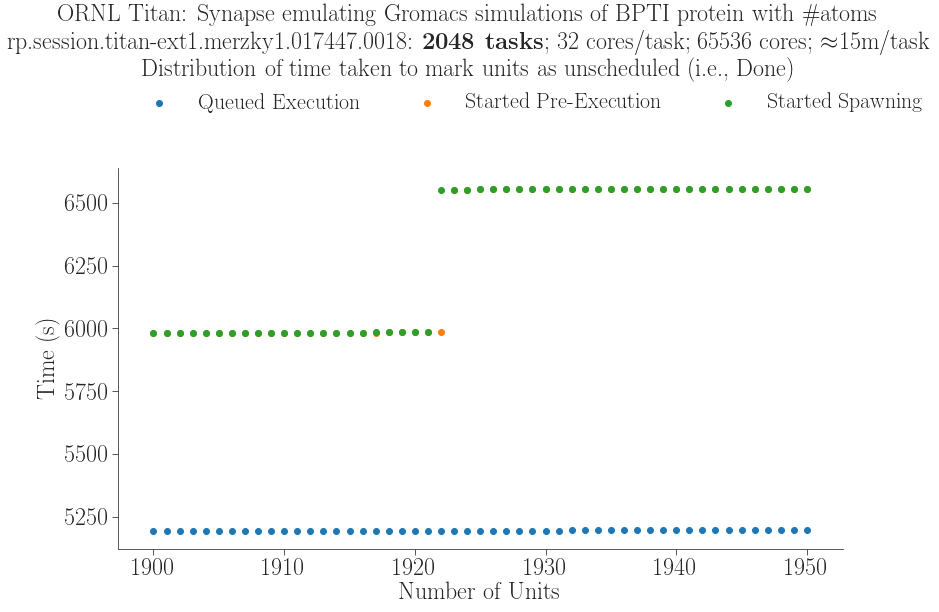

In [27]:
session = sras[2048][1]
fig, ax = fig_setup()

title_head = 'ORNL Titan: Synapse emulating Gromacs simulations of BPTI protein with \#atoms'
title_work = '%s: \\textbf{2048 tasks}; 32 cores/task; 65536 cores; $\\approx$15m/task' % session._sid
title_desc = 'Distribution of time taken to mark units as unscheduled (i.e., Done)'
title = '%s\n%s\n%s' % (title_head, title_work, title_desc)
fig.suptitle(title, y=1.2)

df = getdf_unit_events(session)
df = df.sort_values(by='Scheduled')
df = df.reset_index(drop=True)
df = df.iloc[1900:1951]

# plt.scatter(df['Started Schedule'].index     , df['Started Schedule']     )
# plt.scatter(df['Scheduled'].index            , df['Scheduled']            )
plt.scatter(df['Queued Execution'].index     , df['Queued Execution']     )
plt.scatter(df['Started Pre-Execution'].index, df['Started Pre-Execution'])
plt.scatter(df['Started Spawning'].index     , df['Started Spawning']     )
# plt.scatter(df['Started Execution'].index    , df['Started Execution']    )
# plt.scatter(df['Executed'].index             , df['Executed']             )
# plt.scatter(df['Started Unschedule'].index   , df['Started Unschedule']   )
# plt.scatter(df['Unscheduled'].index          , df['Unscheduled']          )

plt.legend(ncol=3, loc='upper left', bbox_to_anchor=(0,1.25))
plt.xlabel('Number of Units')
plt.ylabel('Time (s)')

# plt.savefig('figures/titan_unit_events_2048_b.pdf', dpi=600, bbox_inches='tight')

In [28]:
session = sras[2048][1]
df = getdf_unit_events(session)
df = df.sort_values(by='Scheduled')
df = df.reset_index(drop=True)
df.iloc[1915:1931][[
                    'uid', 
#                     'Started Schedule',
#                     'Scheduled',
                    'Queuing Execution',
                    'Preparing Execution',
#                    'Queued Execution',
                    'Making directory',
                    'Spawning',
                    'Executing',
                    'Unscheduling'
#                     'Started Pre-Execution',
#                     'Started Make directory',
#                     'Made directory',
#                     'Started Spawning',
#                     'Started Execution',
#                     'Executed',
#                     'Started Unschedule',
#                     'Unscheduled'
                   ]]

,uid,Queuing Execution,Preparing Execution,Making directory,Spawning,Executing,Unscheduling
1915,unit.001784,790.6489,0.0864,NaN,0.0088,874.6434,0.0466
1916,unit.001786,790.6283,0.1437,NaN,0.0213,869.4575,0.0492
1917,unit.001788,790.6484,0.6614,NaN,0.0878,873.8427,0.0453
1918,unit.001790,791.1971,1.2662,NaN,0.0137,872.5656,0.0456
1919,unit.001791,792.3389,0.2731,NaN,0.0336,867.2508,0.0484
1920,unit.001793,792.4901,0.1528,NaN,0.0153,1432.8503,0.0472
1921,unit.001795,792.5377,0.1937,NaN,0.0213,1442.6822,0.0458
1922,unit.001797,792.6133,567.1788,NaN,0.0113,870.4732,0.0464
1923,unit.001799,1359.6517,0.0785,NaN,0.0115,870.4068,0.0451
1924,unit.001801,1359.6124,0.6126,NaN,0.5965,874.8202,0.0455


Note how the two units reponsbile for the delay (unit.001568 and unit.001797) stalls for almost exactly the same amount of time in the spawning (queue of executor?): 567.1560s and 567.1675. This seems way too close to be a coincidence and too regular to be due to a FS stall?

In [29]:
session = sras[2048][1]
df = getdf_unit_events(session)
df = df.sort_values(by='Scheduled')
df = df.reset_index(drop=True)
df[df['Preparing Execution'] > 500][[
    'uid', 
#   'Started Schedule',
#   'Scheduled',
    'Queuing Execution',
    'Preparing Execution',
#    'Queued Execution',
    'Making directory',
    'Spawning',
    'Executing',
    'Unscheduling'
#   'Started Pre-Execution',
#   'Started Make directory',
#   'Made directory',
#   'Started Spawning',
#   'Started Execution',
#   'Executed',
#   'Started Unschedule',
#   'Unscheduled'
    ]]

,uid,Queuing Execution,Preparing Execution,Making directory,Spawning,Executing,Unscheduling
1772,unit.001568,223.0577,567.2781,NaN,0.1221,907.6044,0.0491
1922,unit.001797,792.6133,567.1788,NaN,0.0113,870.4732,0.0464


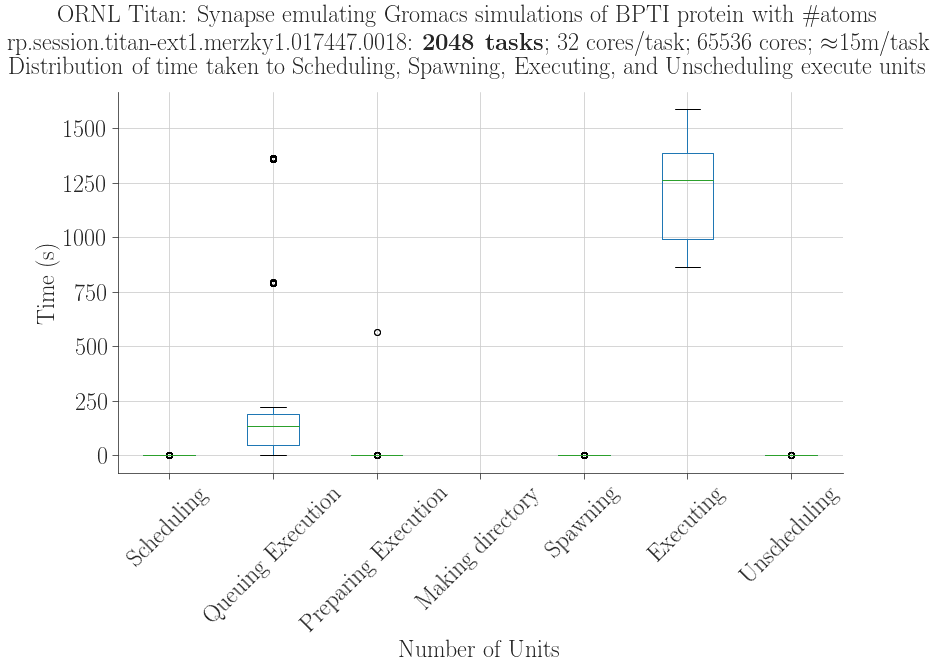

In [30]:
session = sras[2048][1]
fig, ax = fig_setup()

title_head = 'ORNL Titan: Synapse emulating Gromacs simulations of BPTI protein with \#atoms'
title_work = '%s: \\textbf{2048 tasks}; 32 cores/task; 65536 cores; $\\approx$15m/task' % session._sid
title_desc = 'Distribution of time taken to Scheduling, Spawning, Executing, and Unscheduling execute units'
title = '%s\n%s\n%s' % (title_head, title_work, title_desc)
fig.suptitle(title, y=1.05)

df = getdf_unit_events(session)

df[[
    'Scheduling',
    'Queuing Execution',
    'Preparing Execution',
    'Making directory',
    'Spawning',
    'Executing',
    'Unscheduling'
   ]].boxplot(ax=ax, rot=45)

plt.xlabel('Number of Units')
plt.ylabel('Time (s)')

# plt.savefig('figures/titan_unit_events_2048_b.pdf', dpi=600, bbox_inches='tight')

# Microbenchmarks

Definitions: 
* Ideal Runtime: the time taken by the workload to run on the given resources without any overhead
* Walltime: the walltime asked for the pilot
* Max Walltime: the maximum walltime that can be asked for the given size of the pilot

|N runs| N tasks | N core/task | N generations | N pilot | N core/pilot | Ideal Runtime  | Walltime | Max Walltime | Resource |
|------|---------|-------------|---------------|---------|--------------|----------------|----------|--------------|----------|
| 2    | 32      | 32          | 1             | 1       | 1024         | 15m            | 1h       | 1h           | Titan    |
| 2    | 64      | 32          | 1             | 1       | 2048         | 15m            | 1h       | 6h           | Titan    |
| 2    | 128     | 32          | 1             | 1       | 4096         | 15m            | 1h       | 6h           | Titan    |
| 2    | 256     | 32          | 1             | 1       | 8192         | 15m            | 1h       | 12h          | Titan    |
| 2    | 512     | 32          | 1             | 1       | 16384        | 15m            | 1h       | 12h          | Titan    |
| 2    | 1024    | 32          | 1             | 1       | 32768        | 15m            | 1h       | 12h          | Titan    |
| 2    | 2048    | 32          | 1             | 1       | 65536        | 15m            | 1h       | 24h          | Titan    |
| 2    | 4096    | 32          | 1             | 1       | 131072       | 15m            | 1h       | 24h          | Titan    |
| 2    | 8192    | 32          | 1             | 1       | 262144       | 15m            | 1h       | 24h          | Titan    |

In [31]:
# Load sessions for Synapse experiment 1
mb_sras = load_sessions('/Users/mturilli/Projects/RADICAL/github/experiments/rp-paper-ipdps2018/analysis/data/microbenchmarks', 
                        mb_sessions, 
                        sorted(mb_sessions.nunit.unique().tolist()))

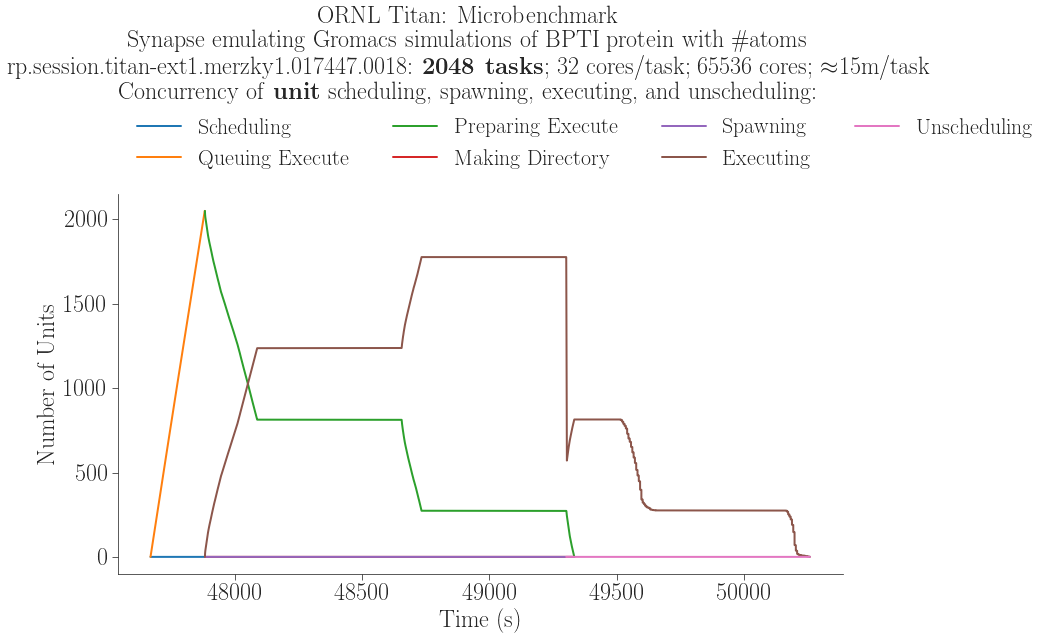

In [32]:
fig, ax = fig_setup()
session = mb_sras[2048][0]

title_head = 'ORNL Titan: Microbenchmark\nSynapse emulating Gromacs simulations of BPTI protein with \#atoms'
title_work = '%s: \\textbf{2048 tasks}; 32 cores/task; 65536 cores; $\\approx$15m/task' % sras[2048][1]._sid
title_desc = 'Concurrency of \\textbf{unit} scheduling, spawning, executing, and unscheduling:  '
title = '%s\n%s\n%s' % (title_head, title_work, title_desc)
fig.suptitle(title, y=1.25)

# How many units are being scheduled
scu = session.concurrency(event=[
 {ru.STATE: None, ru.EVENT: 'schedule_try'},               # Scheduling start
 {ru.STATE: None, ru.EVENT: 'schedule_ok'}])               # Scheduling stop
x = [item[0] for item in scu]
y = [item[1] for item in scu]
ax.plot(x, y) #, color=tableau20[6])

# How many units are being queued for execution
scu = session.concurrency(event=[
 {ru.STATE: 'AGENT_EXECUTING_PENDING', ru.EVENT: 'state'}, # Queuing Execution start
 {ru.STATE: 'AGENT_EXECUTING', ru.EVENT: 'state'}])        # Queuing Execution stop  
x = [item[0] for item in scu]
y = [item[1] for item in scu]
ax.plot(x, y) #, color=tableau20[4])

# How many units are being prepared for execution
scu = session.concurrency(event=[
 {ru.STATE: 'AGENT_EXECUTING', ru.EVENT: 'state'},         # Preparing Execution start
 {ru.STATE: None, ru.EVENT: 'exec_start'}])                # Preparing Execution stop
x = [item[0] for item in scu]
y = [item[1] for item in scu]
ax.plot(x, y) #, color=tableau20[12])

# How many units are being held while their directories are being created
scu = session.concurrency(event=[
 {ru.STATE: None, ru.EVENT: 'exec_mkdir'},                 # Creating Directory start
 {ru.STATE: None, ru.EVENT: 'exec_mkdir_done'}])           # Creating Directory stop
x = [item[0] for item in scu]
y = [item[1] for item in scu]
ax.plot(x, y) #, color=tableau20[14])

# How many units are being spawned
scu = session.concurrency(event=[
 {ru.STATE: None, ru.EVENT: 'exec_start'},                 # Spawning start 
 {ru.STATE: None, ru.EVENT: 'exec_ok'}])                   # Spawned
x = [item[0] for item in scu]
y = [item[1] for item in scu]
ax.plot(x, y) #, color=tableau20[0])

# How many units are being executed
scu = session.concurrency(event=[
 {ru.STATE: None, ru.EVENT: 'exec_ok'},                    # Execution start
 {ru.STATE: None, ru.EVENT: 'exec_stop'}])                 # Executed
x = [item[0] for item in scu]
y = [item[1] for item in scu]
ax.plot(x, y) #, color=tableau20[0])

# How many units are being unscheduled
scu = session.concurrency(event=[
 {ru.STATE: None, ru.EVENT: 'unschedule_start'},           # Unscheduling start
 {ru.STATE: None, ru.EVENT: 'unschedule_stop'}])           # Unscheduling stop
x = [item[0] for item in scu]
y = [item[1] for item in scu]
ax.plot(x, y) #, color=tableau20[8])

ax.legend(ncol=4, loc='upper left', bbox_to_anchor=(0,1.25),
          labels=['Scheduling', 'Queuing Execute', 'Preparing Execute', 
                  'Making Directory', 'Spawning', 'Executing', 'Unscheduling'])
plt.xlabel('Time (s)')
plt.ylabel('Number of Units')

plt.savefig('figures/titan_agent_microbenchmark_concurrency_2048.pdf', dpi=600, bbox_inches='tight')

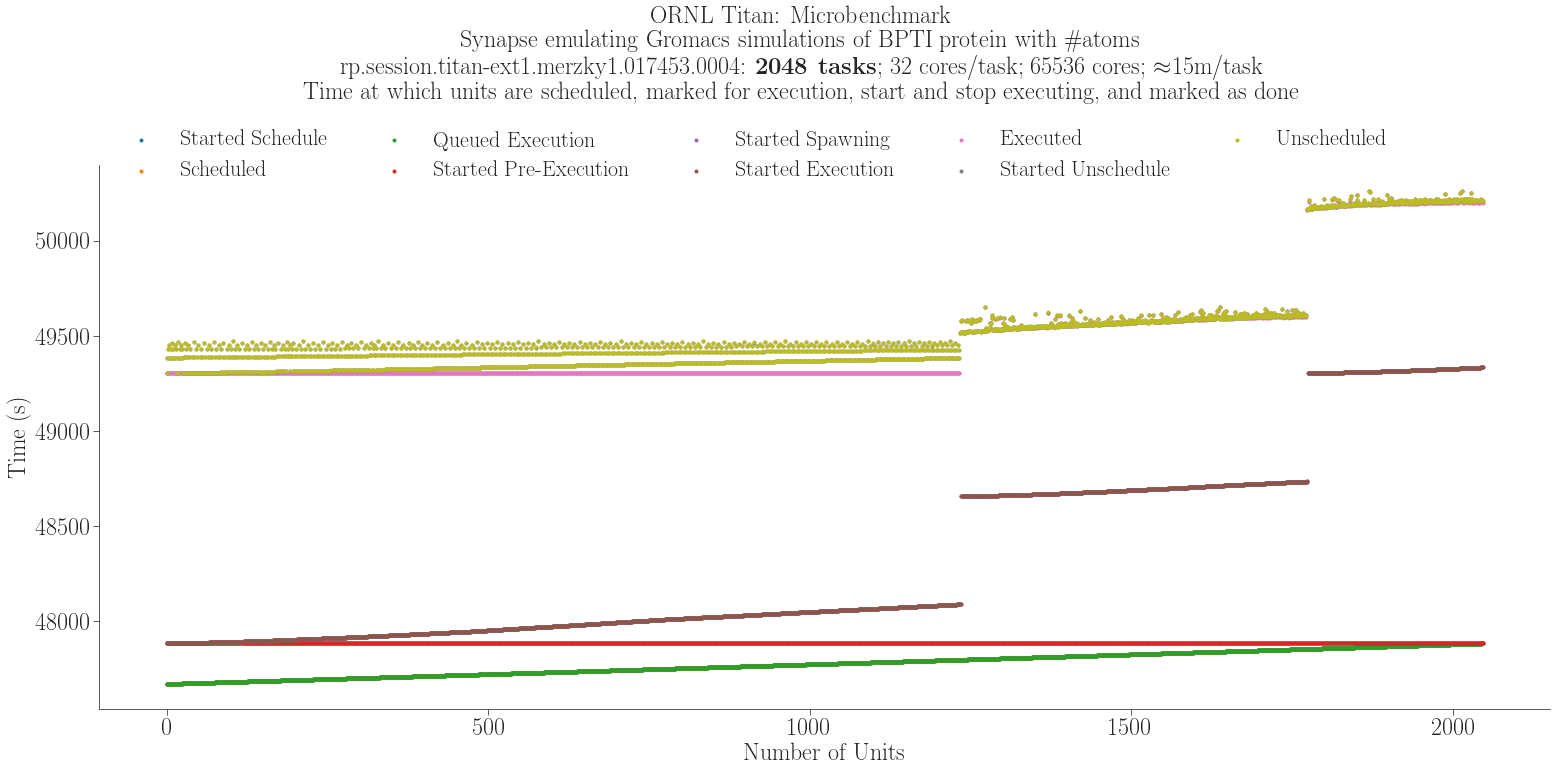

In [33]:
session = mb_sras[2048][0]
fig = plt.figure(figsize=(26,10))
ax = fig.add_subplot(111)  
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)  
ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left()

title_head = 'ORNL Titan: Microbenchmark\nSynapse emulating Gromacs simulations of BPTI protein with \#atoms'
title_work = '%s: \\textbf{2048 tasks}; 32 cores/task; 65536 cores; $\\approx$15m/task' % session._sid
title_desc = 'Time at which units are scheduled, marked for execution, start and stop executing, and marked as done'
title = '%s\n%s\n%s' % (title_head, title_work, title_desc)
fig.suptitle(title, y=1.1)

# Get events and order them by Scheduling
df = getdf_unit_events(session)
df = df.sort_values(by='Scheduled')
df = df.reset_index(drop=True)

plt.scatter(df['Started Schedule'].index     , df['Started Schedule']     , marker='.')
plt.scatter(df['Scheduled'].index            , df['Scheduled']            , marker='.')
plt.scatter(df['Queued Execution'].index     , df['Queued Execution']     , marker='.')
plt.scatter(df['Started Pre-Execution'].index, df['Started Pre-Execution'], marker='.')
plt.scatter(df['Started Spawning'].index     , df['Started Spawning']     , marker='.')
plt.scatter(df['Started Execution'].index    , df['Started Execution']    , marker='.')
plt.scatter(df['Executed'].index             , df['Executed']             , marker='.')
plt.scatter(df['Started Unschedule'].index   , df['Started Unschedule']   , marker='.')
plt.scatter(df['Unscheduled'].index          , df['Unscheduled']          , marker='.')

plt.legend(ncol=5, loc='upper left', bbox_to_anchor=(0,1.1))
plt.xlabel('Number of Units')
plt.ylabel('Time (s)')

# plt.savefig('figures/titan_unit_events_2048_b.pdf', dpi=600, bbox_inches='tight')

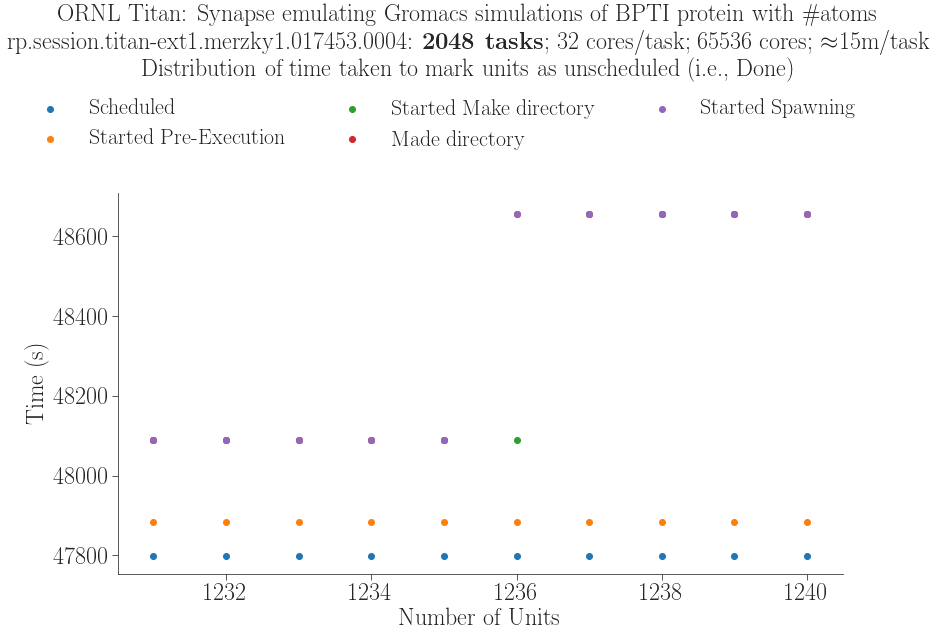

In [34]:
session = mb_sras[2048][0]
fig, ax = fig_setup()

title_head = 'ORNL Titan: Synapse emulating Gromacs simulations of BPTI protein with \#atoms'
title_work = '%s: \\textbf{2048 tasks}; 32 cores/task; 65536 cores; $\\approx$15m/task' % session._sid
title_desc = 'Distribution of time taken to mark units as unscheduled (i.e., Done)'
title = '%s\n%s\n%s' % (title_head, title_work, title_desc)
fig.suptitle(title, y=1.25)

df = getdf_unit_events(session)
df = df.sort_values(by='Scheduled')
df = df.reset_index(drop=True)
df = df.iloc[1231:1241]

# plt.scatter(df['Started Schedule'].index     , df['Started Schedule'])
plt.scatter(df['Scheduled'].index            , df['Scheduled'])
# plt.scatter(df['Queued Execution'].index     , df['Queued Execution'])
plt.scatter(df['Started Pre-Execution'].index, df['Started Pre-Execution'])
plt.scatter(df['Started Make directory'].index, df['Started Make directory'])
plt.scatter(df['Made directory'].index       , df['Made directory'])
plt.scatter(df['Started Spawning'].index     , df['Started Spawning'])
# plt.scatter(df['Started Execution'].index    , df['Started Execution'])
# plt.scatter(df['Executed'].index             , df['Executed'])
# plt.scatter(df['Started Unschedule'].index   , df['Started Unschedule'])
# plt.scatter(df['Unscheduled'].index          , df['Unscheduled'])

plt.legend(ncol=3, loc='upper left', bbox_to_anchor=(-0.15,1.3))
plt.xlabel('Number of Units')
plt.ylabel('Time (s)')

# plt.savefig('figures/titan_unit_events_2048_b.pdf', dpi=600, bbox_inches='tight')

In [35]:
session = mb_sras[2048][0]
df = getdf_unit_events(session)
df = df.sort_values(by='Scheduled')
df = df.reset_index(drop=True)
df[df['Preparing Execution'] > 500][[
    'uid', 
#   'Started Schedule',
#   'Scheduled',
    'Queuing Execution',
    'Preparing Execution',
#    'Queued Execution',
    'Making directory',
    'Spawning',
    'Executing',
    'Unscheduling'
#   'Started Pre-Execution',
#   'Started Make directory',
#   'Made directory',
#   'Started Spawning',
#   'Started Execution',
#   'Executed',
#   'Started Unschedule',
#   'Unscheduled'
    ]]

,uid,Queuing Execution,Preparing Execution,Making directory,Spawning,Executing,Unscheduling
1236,unit.001236,85.9659,772.4649,567.0772,0.0082,920.9866,0.0404
1237,unit.001237,85.8594,772.5658,0.0771,0.0085,920.9241,0.0387
1238,unit.001238,85.7552,772.6648,0.0563,0.0086,864.8512,0.0390
1239,unit.001239,85.6521,772.7351,0.0538,0.0082,859.7356,0.0392
1240,unit.001240,85.5500,772.8063,0.0543,0.0086,864.7368,0.0391
1241,unit.001241,85.4460,772.8494,0.0230,0.0085,864.6676,0.0387
1242,unit.001242,85.3414,772.8653,0.0010,0.0083,859.6065,0.0399
1243,unit.001243,85.2350,772.9337,0.0528,0.0082,920.5201,0.0393
1244,unit.001244,85.1264,773.0398,0.0758,0.0083,864.4782,0.0400
1245,unit.001245,85.0220,773.1198,0.0635,0.0087,925.4141,0.0390


# Gromacs

## Weak Scaling (exp1)

Definitions: 
* Weak scalability: how the solution time varies with the number of processors for a fixed problem size per processor
* Ideal Runtime: the time taken by the workload to run on the given resources without any overhead
* Walltime: the walltime asked for the pilot
* Max Walltime: the maximum walltime that can be asked for the given size of the pilot

|N runs| N tasks | N core/task | N generations | N pilot | N core/pilot | Ideal Runtime  | Walltime | Max Walltime | Resource |
|------|---------|-------------|---------------|---------|--------------|----------------|----------|--------------|----------|
| 2    | 32      | 32          | 1             | 1       | 1024         | 15m            | 1h       | 1h           | Titan    |
| 2    | 64      | 32          | 1             | 1       | 2048         | 15m            | 1h       | 6h           | Titan    |
| 2    | 128     | 32          | 1             | 1       | 4096         | 15m            | 1h       | 6h           | Titan    |
| 2    | 256     | 32          | 1             | 1       | 8192         | 15m            | 1h       | 12h          | Titan    |
| 2    | 512     | 32          | 1             | 1       | 16384        | 15m            | 1h       | 12h          | Titan    |
| 2    | 1024    | 32          | 1             | 1       | 32768        | 15m            | 1h       | 12h          | Titan    |
| 2    | 2048    | 32          | 1             | 1       | 65536        | 15m            | 1h       | 24h          | Titan    |
| 2    | 4096    | 32          | 1             | 1       | 131072       | 15m            | 1h       | 24h          | Titan    |
| 2    | 8192    | 32          | 1             | 1       | 262144       | 15m            | 1h       | 24h          | Titan    |

In [36]:
gromacs_wscaling = gromacs_sessions[gromacs_sessions.experiment == 'exp0'][
    ['nunit','TTC','U_AGENT_EXECUTING','P_LRMS_QUEUING']
        ].groupby(['nunit']).aggregate(
                {'TTC'  : ['mean','std'],
                 'U_AGENT_EXECUTING': ['mean','std'],
                 'P_LRMS_QUEUING': ['mean','std']})

gromacs_wscaling.rename_axis({'U_AGENT_EXECUTING':'TTX'}, axis='columns', inplace=True)
gromacs_wscaling.rename_axis({'P_LRMS_QUEUING':'TTQ'}, axis='columns', inplace=True)
gromacs_wscaling

TTC            TTQ           TTX    
            mean std       mean std      mean std
nunit                                            
16384  4296.2154 NaN  2243.1948 NaN  1929.718 NaN

(-0.5, 0.625)

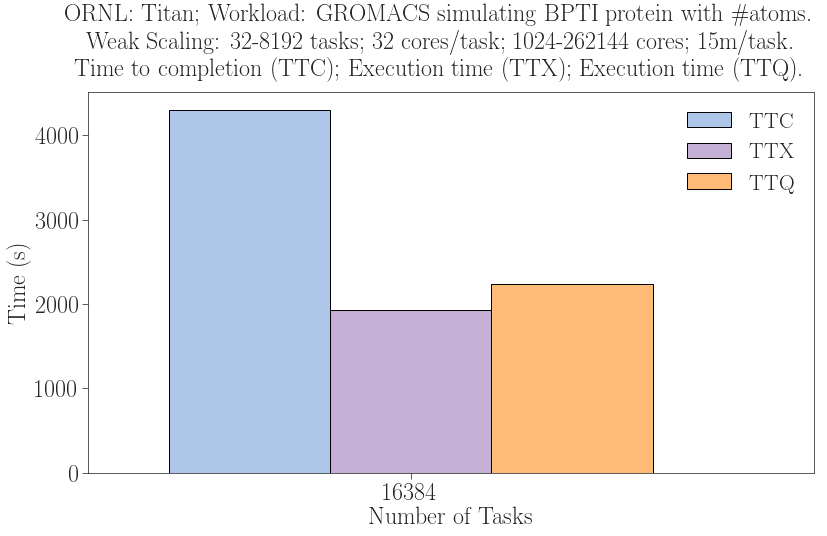

In [37]:
fig = plt.figure(figsize=(13,7))
ax = fig.add_subplot(111)  

title_head = 'ORNL: Titan; Workload: GROMACS simulating BPTI protein with \#atoms.'
title_work = 'Weak Scaling: 32-8192 tasks; 32 cores/task; 1024-262144 cores; 15m/task.' 
title_desc = 'Time to completion (TTC); Execution time (TTX); Execution time (TTQ).'
title = '%s\n%s\n%s' % (title_head, title_work, title_desc)
fig.suptitle(title, y=1.05)

# Plot means and std bars
gromacs_wscaling['TTC'].reset_index().plot(
    x='nunit', y='mean', yerr='std',
    position=1.5, width=0.25, color=tableau20[1], ax=ax, rot=0,
    label='TTC', kind='bar')

gromacs_wscaling['TTX'].reset_index().plot(
    x='nunit', y='mean', yerr='std', 
    position=0.5, width=0.25, color=tableau20[9], ax=ax, rot=0,
    label='TTX', kind='bar')

gromacs_wscaling['TTQ'].reset_index().plot(
    x='nunit', y='mean', yerr='std',
    position=-0.5, width=0.25, color=tableau20[3], ax=ax, rot=0,
    label='TTQ', kind='bar')

ax.set_xlabel('Number of Tasks')
ax.set_ylabel('Time (s)')
ax.set_xlim(-0.5)

#plt.savefig('figures/weak_scaling.pdf', dpi=600, bbox_inches='tight')